<a href="https://colab.research.google.com/github/JyJumu/TFM/blob/main/TFM_JLA_experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experimento

En este notebook trabajamos con los péptidos del conjunto de datos _all_veltri.csv_ en el que tenemos péptidos etiquetados como AMP y no AMP. En concreto, usaremos de ese conjunto de datos, un subconjunto de 2000 péptidos, siendo 1000 de ellos AMP y 1000 no AMP.

Sobre el subconjunto de datos aplicaremos el modelo basado en transformers y obtendremos los vectores de atención de acuerdo con los modelos _Attention Rollout_, _Attention Flow_ y un modelo base o baseline que usaremos como referencia para comparar los resultados obtenido con los dos primeros métodos. En concreto, para cada método tomaremos los vectores de atención de la última de cada péptido desde el token de clasificación `[CLS]`.

Una vez obtenidos estos vectores de atención con cada método, nos quedaremos, para cada péptido, con el valor máximo de atención de cada uno de los aminoácidos que hay en dicho péptido, es decir, si existe un aminoácido que esté presente en tres partes del péptido, guardamos el valor máximo de atención de esas tres apariciones. Si hay algún aminoácido que no esté presente, entonces le asignaremos valor cero.

De esta manera, crearemos un conjunto de datos en el que las instancias -filas- son los 2000 péptidos de nuestro subconjunto de datos y los predictores son los posibles aminoácidos que puede haber en un péptido. El valor de estos predictores son los valores de atención anteriores. Además, los péptidos de este conjunto de datos también están etiquetados según capacidad antimicrobiana -AMP-.

Sobre el último conjunto de datos, realizaremos un análisis estadístico para estudiar si el token de clasificación `[CLS]` fija su atención en algunos aminoácidos en concreto para realizar la predicción. Para ello, realizaremos los siguientes análisis:

* Visualización de la matriz de correlaciones para estudiar qué aminoácidos están correlacionados con la etiqueta AMP.

* Visualización con un diagrama de cajas de los valores de atención obtenidos para cada uno de los aminoácidos agrupados por péptidos AMP.

* Visualización con un gráfico de barras de la atención media por aminoácido y valor de la etiqueta AMP.

* Test estadístico para estudiar qué aminoácidos son estadísticamente significativos en la predicción de los péptidos.

* Entrenamiento y validación de un modelo de Machine Learning, una regresión logística. Estudiaremos las métricas f1-score, accuracy, recall y la curva ROC-AUC.

Para realizar el experimento, primero importamos las librerías necesarias:

In [ ]:
import pandas as pd
import re
# Si el modelo es binario (AMP vs no-AMP), puedes aplicar softmax o sigmoid según el caso:
import torch.nn.functional as F

Cargamos el conjunto de datos, tratamos todas péptidos para que podamos trabajar con ellas y seleccionamos 100 péptidos AMP y 100 no AMP:

In [ ]:
# Leemos los datos
data = pd.read_csv('all_veltri.csv')

# Nos quedamos con las columnas que contienen las proteínas y la etiqueta
proteinas = data.drop(columns=['id', 'aa_len'])

# Modificamos las proteínas para que el encoder las pueda leer correctamente
proteinas['aa_seq'] = proteinas['aa_seq'].apply(lambda x:
                                                ' '.join([ x[i:i+1] for i in range(0, len(x), 1) ]))
proteinas['aa_seq'] = proteinas['aa_seq'].apply(lambda x:
                                          re.sub(r'[UZOB]', 'X', x))

# Nos quedamos con solo una muestra de nuestro conjunto de datos
muestra = proteinas.groupby('AMP').apply(lambda x: x.sample(n=1000, replace = True, random_state=42))
muestra = muestra.reset_index(drop=True)

/tmp/ipython-input-2-2551012267.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  muestra = proteinas.groupby('AMP').apply(lambda x: x.sample(n=1000, replace = True, random_state=42))


Comprobamos que hemos tratado correctamente los datos:

In [ ]:
data.head()

,id,aa_seq,aa_len,AMP
0,AP00085,SLFSLIKAGAKFLGKNLLKQGACYAACKASKQC,33,True
1,AP00652,GIMDTVKNVAKNLAGQLLDKLKCKITAC,28,True
2,AP00714,GYGCPFNQYQCHSHCSGIRGYKGGYCKGTFKQTCKCY,37,True
3,AP00269,LSCKRGTCHFGRCPSHLIKGSCSGG,25,True
4,AP00765,MHDFWVLWVLLEYIYNSACSVLSATSSVSSRVLNRSLQVKVVKITN,46,True


In [ ]:
muestra.head()

,aa_seq,AMP
0,E P R D G S G G Q N S N N S T V G,False
1,S C T G Q E M K Q S S E A D R R S P E G E R R ...,False
2,R D G L R A A A M K P I A A G A T L V N G V L ...,False
3,V R R V D A A A A E V D A L M R Q A L G L T P Q,False
4,C T R F I S K E I L T I R E A V W L T D N T Y ...,False


### Cargamos el modelo

Cargamos el modelo y las librerías:

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

El modelo usado es un modelo preentrenado para etiquetar correctamente los péptidos según su propiedad antimicrobiana (AMP).

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Usamos el tokenizador de AMPBERT original
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd")
# Y el modelo fine-tuneado que te pasaron
model = BertForSequenceClassification.from_pretrained("alexcis95/amp_bert_rep", output_attentions=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

# Modelo baseline

El primer modelo que vamos a aplicar es el modelo base. Este modelo es muy simple, únicamente obtenemos todos los vectores de atención de todas las cabezas de la última capa y calculamos la media de los valores obtenidos entre las distintas cabezas de atención.

## Funciones auxiliares para obtener los vectores de atención

In [ ]:
def get_avg_cls_attention_vector(sequence):
    # Preprocesar la secuencia como proteína (espaciado entre aminoácidos)
    inputs = tokenizer(sequence, return_tensors="pt")

    # Ejecutar el modelo
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Lista de tensores: (batch_size, num_heads, seq_len, seq_len)

    # Última capa de atención
    last_layer_attention = attentions[-1]  # Shape: (1, num_heads, seq_len, seq_len)

    # Atenciones desde el token [CLS] hacia todos los demás tokens
    # Seleccionamos solo la fila correspondiente al token [CLS], que es el primero: index 0
    cls_attention_vectors = last_layer_attention[0, :, 0, :]  # Shape: (num_heads, seq_len)

    # Promediar las atenciones del token [CLS] sobre todas las cabezas
    avg_cls_attention = cls_attention_vectors.mean(dim=0)  # Shape: (seq_len,)

    return avg_cls_attention


### Obtención de los vectores

A continuación, procedemos a la obtención de todos los vectores de atención usando las funciones auxiliares anteriores. Para ello, vamos a iterar sobre nuestro conjunto de datos `muestra`, que contiene mil péptidos no AMP y mil AMP.

Como hemos comentado anteriormente, obtenemos los vectores de atención de estos péptidos para estudiar los péptidos de cada proteína que reciben más atención por parte del token de clasificación `CLS` para realizar la predicción.

In [ ]:
vectores_atencion_baseline = []

# Recorremos todas las proteínas que hemos tomado como muestra
for index, row in muestra.iterrows():
  #Obtenemos el vector de atención
  v_atencion = get_avg_cls_attention_vector(row['aa_seq'])

  # Guardamos el vector de atención en la lista "vectores_atencion"
  vectores_atencion_baseline.append(v_atencion)


Normalizamos los vectores de atención de manera global. Realizamos esta normalización porque queremos realizar una comparativa global entre los tres modelos de explicabilidad y, para ello, han de estar los tres modelos en la misma escala.

Otra posibilidad de normalización habría sido entre los valores de atención de cada vector de atención, es decir, normalizar por péptido. Sin embargo, en caso de haber realizado esta normalización, la comparativa entre los modelos no sería buena porque se perdería la información de la distribución dada por cada modelo, ya que dejaríamos de conocer cómo distribuye cada modelo los valores entre cada péptido.

In [ ]:
all_attention_values = torch.cat(vectores_atencion_baseline)
global_min = all_attention_values.min()
global_max = all_attention_values.max()

vectores_atencion_baseline_norm = []
for v in vectores_atencion_baseline:
    if global_max > global_min:
        v_norm = (v - global_min) / (global_max - global_min)
    else:
        v_norm = torch.zeros_like(v)
    vectores_atencion_baseline_norm.append(v_norm)

Ahora creamos una lista de diccionarios. Cada diccionario de la lista se corresponde con una de los péptidos para las cuales hemos calculado los vectores de atención. Todos los diccionarios tienen como claves a los posibles péptidos de cualquier péptido, y los valores de cada una de las claves son cero si ese péptido no aparece en el péptido y, en caso de estar, el valor máximo del vector de atención de el péptido en cuestión.

In [ ]:
# Aminoácidos estándar
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Creamos un diccionario por proteína
protein_attention_dicts_baseline = []

proteinas = muestra['aa_seq'].str.replace(' ', '')

for seq, att in zip(proteinas, vectores_atencion_baseline_norm):
    attention_dict = dict.fromkeys(amino_acids, 0.0)
    for aa, value in zip(seq, att):
        if value.item() > attention_dict[aa]:
            attention_dict[aa] = value.item()
    protein_attention_dicts_baseline.append(attention_dict)


'''
# Resultado: lista de diccionarios
for i, d in enumerate(protein_attention_dicts_baseline):
    print(f"Proteína {i+1}:")
    print(d)
'''



'\n# Resultado: lista de diccionarios\nfor i, d in enumerate(protein_attention_dicts_baseline):\n    print(f"Proteína {i+1}:")\n    print(d)\n'

Convertimos el diccionario en un DataFrame de pandas:

In [ ]:
df_attention_baseline = pd.DataFrame(protein_attention_dicts_baseline)
df_attention_baseline['AMP'] = muestra['AMP']
df_attention_baseline

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,AMP
0,0.000000,0.000000,0.075609,0.105907,0.000000,0.096418,0.000000,0.000000,0.000000,0.000000,...,0.105928,0.118044,0.089162,0.101188,0.103811,0.098427,0.100817,0.000000,0.000000,False
1,0.065292,0.065064,0.059614,0.069956,0.000000,0.067671,0.000000,0.000000,0.048366,0.000000,...,0.000000,0.068083,0.058529,0.073151,0.081866,0.058359,0.000000,0.000000,0.000000,False
2,0.053088,0.000000,0.058101,0.015907,0.024318,0.036807,0.038030,0.046391,0.050792,0.031151,...,0.015455,0.026306,0.011266,0.077218,0.016118,0.033328,0.019501,0.000000,0.000000,False
3,0.081416,0.000000,0.068522,0.070749,0.000000,0.075683,0.000000,0.000000,0.000000,0.078826,...,0.000000,0.075969,0.073387,0.071191,0.000000,0.061455,0.069019,0.000000,0.000000,False
4,0.055137,0.046004,0.052822,0.062826,0.049677,0.053605,0.000000,0.053416,0.051748,0.059982,...,0.048233,0.000000,0.000000,0.063362,0.049469,0.052788,0.055161,0.051917,0.057428,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.089568,0.000000,0.000000,0.000000,0.067114,0.685700,0.000000,0.074815,0.074312,0.083272,...,0.049462,0.000000,0.000000,0.000000,0.058915,0.049014,0.000000,0.000000,0.000000,True
1996,0.084010,0.049687,0.000000,0.000000,0.537707,0.051801,0.000000,0.061399,0.062905,0.067492,...,0.000000,0.059249,0.000000,0.046865,0.038505,0.000000,0.000000,0.000000,0.000000,True
1997,0.034975,0.000000,0.164048,0.024704,0.157215,0.032908,0.016621,0.265336,0.039012,0.031891,...,0.018027,0.030427,0.016268,0.000000,0.000000,0.000000,0.252454,0.000000,0.000000,True
1998,0.096312,0.000000,0.000000,0.000000,0.075814,0.576384,0.067997,0.000000,0.067148,0.000000,...,0.047990,0.000000,0.000000,0.000000,0.073743,0.031085,0.053594,0.000000,0.000000,True


In [ ]:
# Guardar
df_attention_baseline.to_parquet("attention_baseline.parquet")

from google.colab import files
files.download("attention_baseline.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cargar
df_attention_baseline = pd.read_parquet("attention_baseline.parquet")

## Análisis exploratorio de los datos

Vamos a realizar el análisis exploratorio de los datos. Empezamos con la matriz de correlación de los valores de atención de los *aminoácidos*:

### Matriz de correlaciones

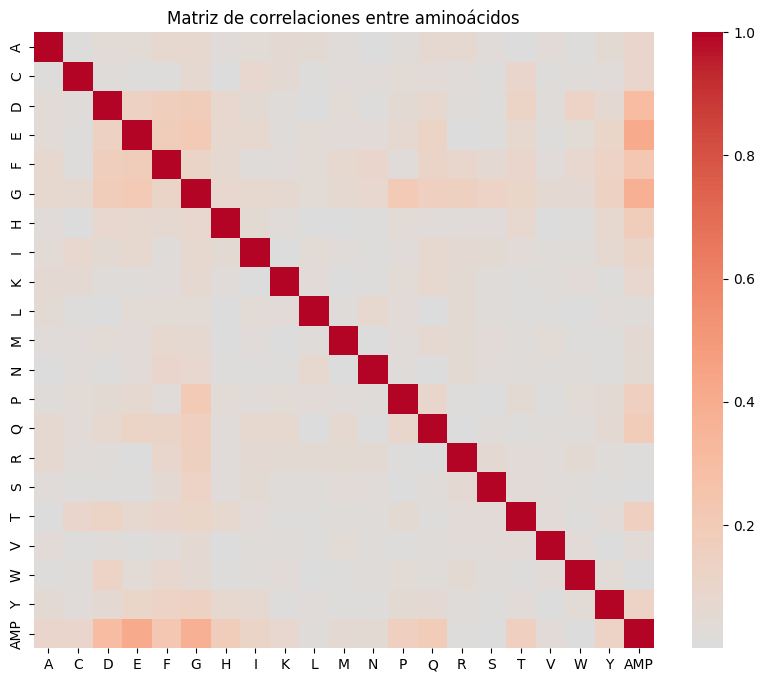

In [ ]:
correlation_matrix_baseline = df_attention_baseline.corr()
correlation_matrix_abs_baseline = correlation_matrix_baseline.abs()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_abs_baseline, cmap='coolwarm', center=0)
plt.title("Matriz de correlaciones entre aminoácidos")
plt.show()

En la matriz de correlaciones vamos a fijarnos en la última fila. En ella podemos ver la correlación entre la etiqueta AMP y cada uno de los aminoácidos. Como podemos comprobar, los aminoácidos más correlacionados con la predicción son los representados por las letras D, E, F, G, H, P, Q, T e Y.

Además, también podemos ver que, en general, los valores de la matriz de correlación no son muy altos.

### Diagrama de cajas

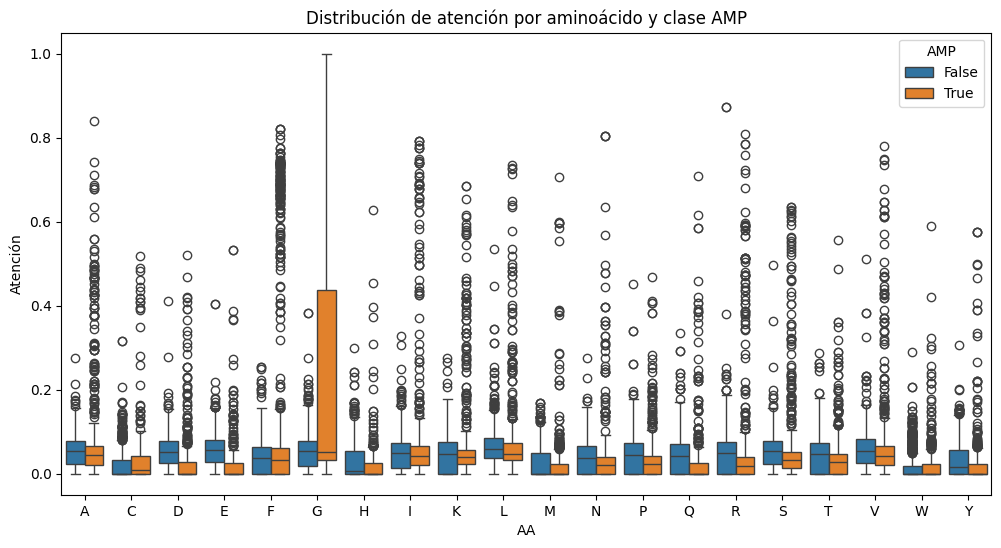

In [ ]:
# Boxplot por clase para algunos aminoácidos representativos
df_melted_baseline = df_attention_baseline.melt(id_vars='AMP', var_name='AA', value_name='Atención')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted_baseline, x='AA', y='Atención', hue='AMP')
plt.title("Distribución de atención por aminoácido y clase AMP")
plt.show()


En el diagrama de cajas podemos ver que, efectivamente, el aminoácido que destaca entre todos es la glicina (G), pues muestra una distribución de los valores de atención muy alargada para los péptidos AMP, lo que parece indicar que el modelo enfoca su atención en este aminoácido para aquellos casos en los que predice positivamente al péptido como AMP.

El resto de aminoácidos muestran distribuciones similares en todos los casos.

### Diagrama de la atención media

<Axes: title={'center': 'Atención media por aminoácido con el modelo base'}>

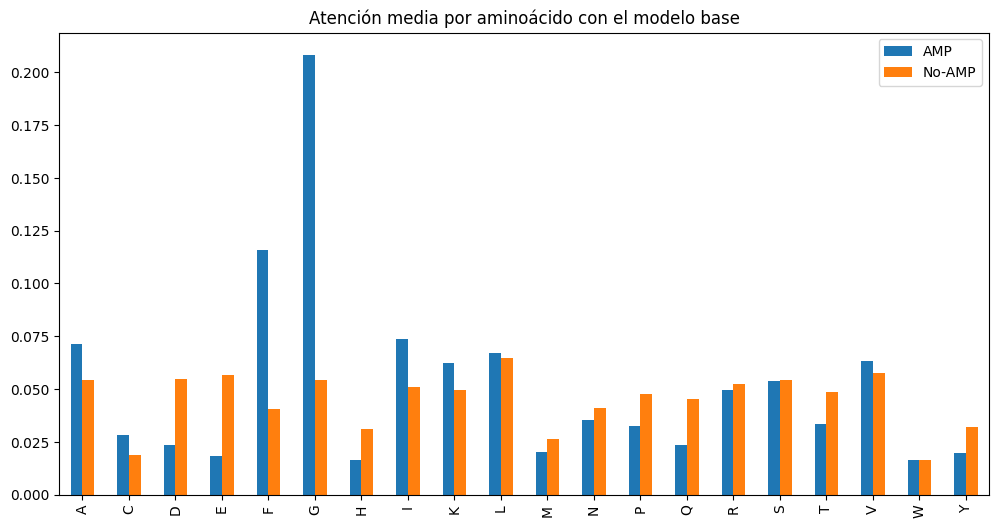

In [ ]:
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")

mean_attn_amp_baseline = df_attention_baseline[df_attention_baseline['AMP'] == True][aa_cols].mean()
mean_attn_noamp_baseline = df_attention_baseline[df_attention_baseline['AMP'] == False][aa_cols].mean()

df_means_baseline = pd.DataFrame({'AMP': mean_attn_amp_baseline, 'No-AMP': mean_attn_noamp_baseline})
df_means_baseline.plot(kind='bar', figsize=(12,6), title="Atención media por aminoácido con el modelo base")

En este diagrama observamos un resultados similar al anterior. El aminoácido con mayor atención media es la glicina (G) con aquellos péptidos AMP.

También destaca el aminoácido F por presentar unos valores medios de atención también elevados para los péptidos AMP.

### Test estadístico

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

p_values_baseline = []

for aa in aa_cols:
    grupo_AMP_baseline = df_attention_baseline[df_attention_baseline['AMP'] == True][aa]
    grupo_noAMP_baseline = df_attention_baseline[df_attention_baseline['AMP'] == False][aa]
    stat_baseline, p_baseline = mannwhitneyu(grupo_AMP_baseline, grupo_noAMP_baseline, alternative='two-sided')
    p_values_baseline.append(p_baseline)

# Corrección FDR
reject_baseline, pvals_corr_baseline, _, _ = multipletests(p_values_baseline, alpha=0.05, method='fdr_bh')

# Resultados en un dataframe
import pandas as pd
df_stats_baseline = pd.DataFrame({
    'AA': aa_cols,
    'p_value': p_values_baseline,
    'p_value_corr': pvals_corr_baseline,
    'significant': reject_baseline
}).sort_values('p_value_corr')

df_stats_baseline


,AA,p_value,p_value_corr,significant
3,E,6.590553e-130,1.318111e-128,True
2,D,5.516085e-108,5.516085e-107,True
13,Q,6.443514e-66,4.295676e-65,True
14,R,5.427407e-37,2.713703e-36,True
16,T,4.088923e-26,1.635569e-25,True
19,Y,8.046239e-26,2.682080e-25,True
12,P,5.200184e-25,1.485767e-24,True
15,S,1.603389e-24,4.008473e-24,True
6,H,1.957674e-17,4.350387e-17,True
11,N,6.529490e-17,1.305898e-16,True


En la tabla se muestran los aminoácidos ordenados según el p-valor del test Mann Whitney U. Este p-valor muestran si hay una diferencia significativa entre los valores de atención de cada aminoácido según la propiedad antimicrobiana de los péptidos.

Como podemos ver, los p-valores corregidos muestran que todos los aminoácidos a excepción de I, F y W, muestran diferencias significativas según la clase de los péptidos.

### Modelos de Machine Learning

#### Regresión logística

Creamos un modelo de regresión logística para comprobar si es capaz de predecir que un péptido sea o no AMP entrenando el modelo con los valores de atención de cada aminoácido vistos desde el token de clasificación `[CLS]`.

Primero dividimos los datos en train y test haciendo una división 80/20 estratificada:

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    accuracy_score, roc_auc_score
)

# Definir columnas de péptidos
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Extraer X e y
X = df_attention_baseline[aa_cols].astype(float)
y = df_attention_baseline['AMP'].astype(int)

# Dividir en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Una vez hecha la división, entrenamos el modelo y obtenemos las métricas para el conjunto de entrenamiento y para el de validación:

In [ ]:
# Entrenar modelo
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred_train_baseline = model.predict(X_train)
y_pred_test_baseline = model.predict(X_test)
y_proba_train_baseline = model.predict_proba(X_train)[:, 1]
y_proba_test_baseline = model.predict_proba(X_test)[:, 1]

# Calcular métricas
conf_matrix_train_baseline = confusion_matrix(y_train, y_pred_train_baseline)
report_train_baseline = classification_report(y_train, y_pred_train_baseline)
f1_train_baseline = f1_score(y_train, y_pred_train_baseline)
accuracy_train_baseline = accuracy_score(y_train, y_pred_train_baseline)
roc_auc_train_baseline = roc_auc_score(y_train, y_proba_train_baseline)

conf_matrix_test_baseline = confusion_matrix(y_test, y_pred_test_baseline)
report_test_baseline = classification_report(y_test, y_pred_test_baseline)
f1_test_baseline = f1_score(y_test, y_pred_test_baseline)
accuracy_test_baseline = accuracy_score(y_test, y_pred_test_baseline)
roc_auc_test_baseline = roc_auc_score(y_test, y_proba_test_baseline)

Dibujamos las matrices de confusión de los conjuntos de train y test:

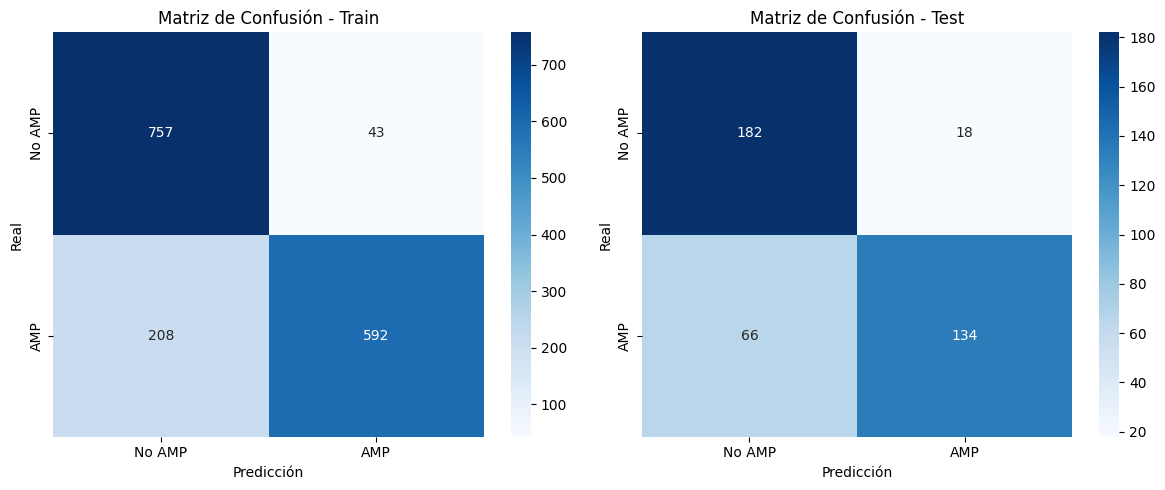

In [ ]:
# Etiquetas de clases (modifícalas si tus clases son otras)
labels = ['No AMP', 'AMP']

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión - Train
sns.heatmap(conf_matrix_train_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Matriz de Confusión - Train')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Matriz de confusión - Test
sns.heatmap(conf_matrix_test_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Matriz de Confusión - Test')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

Observamos que en ambos casos parece que obtenemos resultados similares y que las predicciones son buenas. En su mayoría, la regresión logística logra acertar la predicción de los péptidos usando como referencia los valores de atención del modelo basado en transformers, aunque parece que le es más complicado predecir los péptidos que son AMP. Veamos los valores de las diferentes métricas:

In [ ]:
# Mostrar resultados
print("Métricas del conjunto de entrenamiento:")
print(report_train_baseline)
print("\nMétricas del conjunto de test:")
print(report_test_baseline)


Métricas del conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       800
           1       0.93      0.74      0.83       800

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Métricas del conjunto de test:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       200
           1       0.88      0.67      0.76       200

    accuracy                           0.79       400
   macro avg       0.81      0.79      0.79       400
weighted avg       0.81      0.79      0.79       400



Como podemos observar, los resultados de ambos conjuntos parecen ser similares, aunque hay un ligero sobreajuste a los datos de entrenamiento.

En el entrenamiento tenemos 0.86 de precision frente a un 0.81 en el conjunto de validación, lo que muestra un ligero descenso en la predicción de los péptidos AMP. Para el recall, la diferencia es de 0.84 en el entrenamiento frente a un 0.79 en el test. La puntuación f1 queda con valores 0.84 y 0.79 para train y test, respectivamente. Es por ello por lo que podemos afirmar que el modelo realiza una buena predicción.

Veamos ahora las curvas ROC:

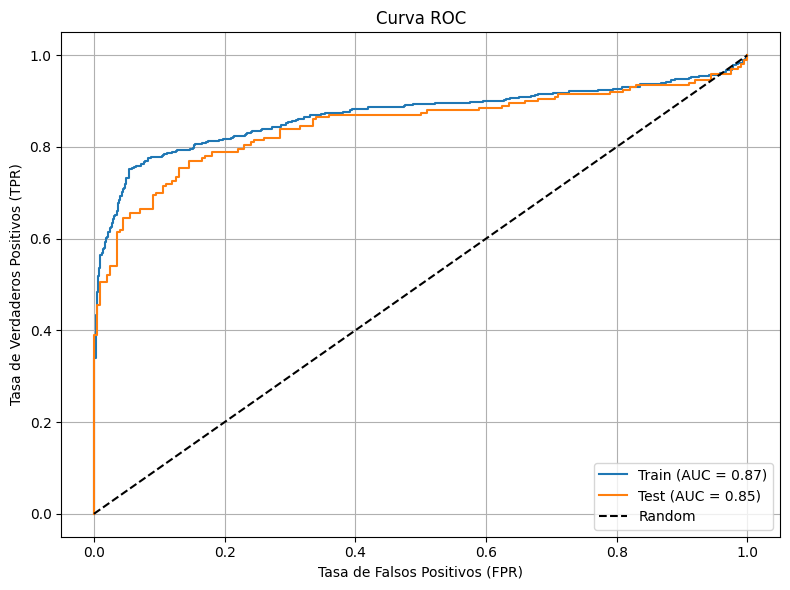

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcular curvas ROC
fpr_train_baseline, tpr_train_baseline, _ = roc_curve(y_train, y_proba_train_baseline)
fpr_test_baseline, tpr_test_baseline, _ = roc_curve(y_test, y_proba_test_baseline)

# Dibujar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_baseline, tpr_train_baseline, label=f'Train (AUC = {roc_auc_train_baseline:.2f})')
plt.plot(fpr_test_baseline, tpr_test_baseline, label=f'Test (AUC = {roc_auc_test_baseline:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


De acuerdo con estas dos curvas, la regresión logística parece hacer buenas predicciones tanto para los conjuntos de entrenamiento y de test.

# Attention Rollout

El siguiente método que aplicamos es Attention Rollout. Veamos si los resultados de este método son tan buenos como parecen prometer.

### Funciones auxiliares para obtener los vectores de atención

Definimos unas funciones auxiliares para obtener el vector de atención desde el token `[CLS]` de la última capa de cada péptido:

In [ ]:
def get_inputs_from_sequence(sequence):
    # Tokenizar secuencia de proteína
    sequence = " ".join(sequence)  # Espacios entre aminoácidos
    inputs = tokenizer(sequence, return_tensors="pt")
    return inputs

# Implementar el cálculo de attention flow (attention rollout)
def compute_attention_rollout(attentions):
    # Inicializar la atención acumulada con la identidad
    rollout = torch.eye(attentions[0].size(-1))
    for attention in attentions:
        # Promediar sobre las cabezas de atención
        attention_heads_fused = attention.mean(dim=1).squeeze(0)
        # Añadir la identidad y normalizar
        attention_heads_fused = attention_heads_fused + torch.eye(attention_heads_fused.size(-1))
        attention_heads_fused = attention_heads_fused / attention_heads_fused.sum(dim=-1, keepdim=True)
        # Multiplicar la atención acumulada
        rollout = torch.matmul(attention_heads_fused, rollout)
    return rollout

def get_attention_rollout_result_from_CLS(sequence):
    inputs = get_inputs_from_sequence(sequence)

    # Pasar la secuencia por el modelo
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Lista de tensores de atención por capa

    attention_rollout = compute_attention_rollout(attentions)

    return attention_rollout[1:-1,1:-1][0]

### Obtención de los vectores

A continuación, procedemos a la obtención de todos los vectores de atención usando las funciones auxiliares anteriores. Para ello, vamos a iterar sobre nuestro conjunto de datos `muestra`, que contiene mil péptidos no AMP y mil AMP.

Como hemos comentado anteriormente, obtenemos los vectores de atención de estos péptidos para estudiar los péptidos de cada proteína que reciben más atención por parte del token de clasificación `CLS` para realizar la predicción.

In [ ]:
vectores_atencion_rollout = []

# Recorremos todas las proteínas que hemos tomado como muestra
for index, row in muestra.iterrows():
  #Obtenemos el vector de atención
  v_atencion = get_attention_rollout_result_from_CLS(row['aa_seq'])

  # Guardamos el vector de atención en la lista "vectores_atencion"
  vectores_atencion_rollout.append(v_atencion)


Normalizamos igual que hemos hecho en el modelo anterior:

In [ ]:
all_attention_values = torch.cat(vectores_atencion_rollout)
global_min = all_attention_values.min()
global_max = all_attention_values.max()

vectores_atencion_rollout_norm = []
for v in vectores_atencion_rollout:
    if global_max > global_min:
        v_norm = (v - global_min) / (global_max - global_min)
    else:
        v_norm = torch.zeros_like(v)
    vectores_atencion_rollout_norm.append(v_norm)

Ahora creamos una lista de diccionarios. Cada diccionario de la lista se corresponde con una de los péptidos para las cuales hemos calculado los vectores de atención. Todos los diccionarios tienen como claves a los posibles péptidos de cualquier péptido, y los valores de cada una de las claves son cero si ese péptido no aparece en el péptido y, en caso de estar, el valor máximo del vector de atención de el péptido en cuestión.

In [ ]:
# Aminoácidos estándar
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Creamos un diccionario por proteína
protein_attention_dicts = []

proteinas = muestra['aa_seq'].str.replace(' ', '')

for seq, att in zip(proteinas, vectores_atencion_rollout_norm):
    attention_dict = dict.fromkeys(amino_acids, 0.0)
    for aa, value in zip(seq, att):
        if value.item() > attention_dict[aa]:
            attention_dict[aa] = value.item()
    protein_attention_dicts.append(attention_dict)


'''
# Resultado: lista de diccionarios
for i, d in enumerate(protein_attention_dicts):
    print(f"Proteína {i+1}:")
    print(d)
'''



'\n# Resultado: lista de diccionarios\nfor i, d in enumerate(protein_attention_dicts):\n    print(f"Proteína {i+1}:")\n    print(d)\n'

Convertimos el diccionario en un DataFrame de pandas:

In [ ]:
df_attention_rollout = pd.DataFrame(protein_attention_dicts)
df_attention_rollout['AMP'] = muestra['AMP']
df_attention_rollout

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,AMP
0,0.000000,0.000000,0.378732,0.339212,0.000000,0.411894,0.000000,0.000000,0.000000,0.000000,...,0.337975,0.301057,0.175368,0.269329,0.312364,0.462206,0.439783,0.000000,0.000000,False
1,0.231657,0.253389,0.297935,0.313965,0.000000,0.348384,0.000000,0.000000,0.162676,0.000000,...,0.000000,0.228603,0.156203,0.225716,0.224040,0.198261,0.000000,0.000000,0.000000,False
2,0.097952,0.000000,0.113363,0.061709,0.122619,0.194230,0.087061,0.125924,0.054702,0.060827,...,0.061570,0.096974,0.037878,0.058275,0.097574,0.112456,0.063896,0.000000,0.000000,False
3,0.233876,0.000000,0.314323,0.288862,0.000000,0.518231,0.000000,0.000000,0.000000,0.235704,...,0.000000,0.247312,0.248140,0.206442,0.000000,0.243371,0.360737,0.000000,0.000000,False
4,0.261811,0.198739,0.199057,0.228537,0.198328,0.533077,0.000000,0.224773,0.129527,0.142655,...,0.153522,0.000000,0.000000,0.194653,0.173349,0.151370,0.182742,0.197727,0.213980,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.229000,0.000000,0.000000,0.000000,0.406221,0.456755,0.000000,0.353366,0.324069,0.350867,...,0.468887,0.000000,0.000000,0.000000,0.337166,0.313157,0.000000,0.000000,0.000000,True
1996,0.355985,0.346522,0.000000,0.000000,0.302758,0.621907,0.000000,0.336226,0.234333,0.250551,...,0.000000,0.246016,0.000000,0.227311,0.224895,0.000000,0.000000,0.000000,0.000000,True
1997,0.255733,0.000000,0.165813,0.234396,0.237788,0.317574,0.191268,0.207488,0.218187,0.204186,...,0.185447,0.180744,0.126364,0.000000,0.000000,0.000000,0.223331,0.000000,0.000000,True
1998,0.311847,0.000000,0.000000,0.000000,0.417360,0.545424,0.298463,0.000000,0.307536,0.000000,...,0.233616,0.000000,0.000000,0.000000,0.250676,0.231420,0.244908,0.000000,0.000000,True


In [ ]:
# Guardar
df_attention_rollout.to_parquet("attention_rollout.parquet")

from google.colab import files
files.download("attention_rollout.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cargar
df_attention_rollout = pd.read_parquet("attention_rollout.parquet")

## Análisis exploratorio de los datos

Vamos a realizar el análisis exploratorio de los datos. Empezamos con la matriz de correlación de los valores de atención de los *aminoácidos*:

### Matriz de correlaciones

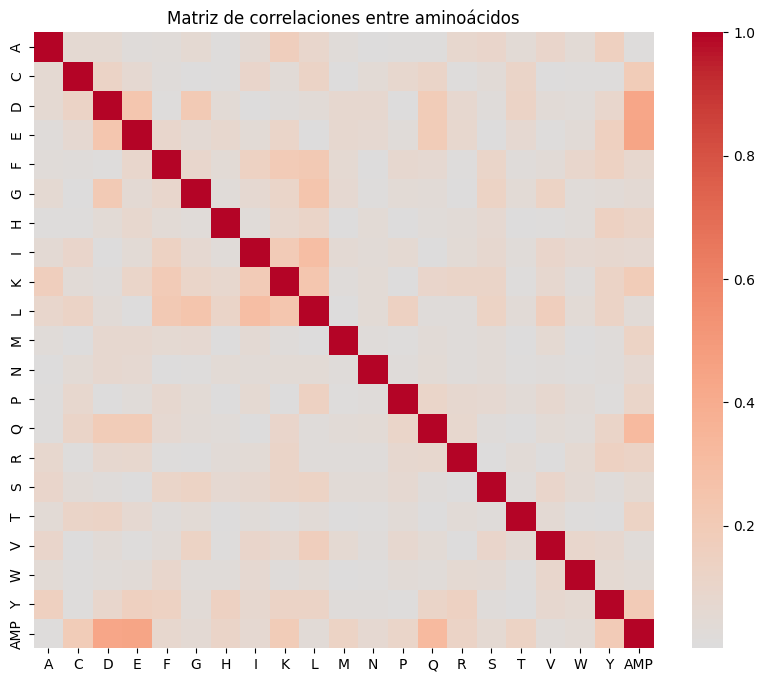

In [ ]:
correlation_matrix_rollout = df_attention_rollout.corr()
correlation_matrix_abs_rollout = correlation_matrix_rollout.abs()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_abs_rollout, cmap='coolwarm', center=0)
plt.title("Matriz de correlaciones entre aminoácidos")
plt.show()

En la matriz de correlaciones vamos a fijarnos en la última fila. En ella podemos ver la correlación entre la etiqueta AMP y cada uno de los aminoácidos. Como podemos comprobar, los aminoácidos más correlacionados con la predicción son los denotados por las letras C, D, E, Q e Y.

Además, parece que, en promedio, obtenemos valores de correlación más elevados que con el método baseline.

### Diagrama de cajas

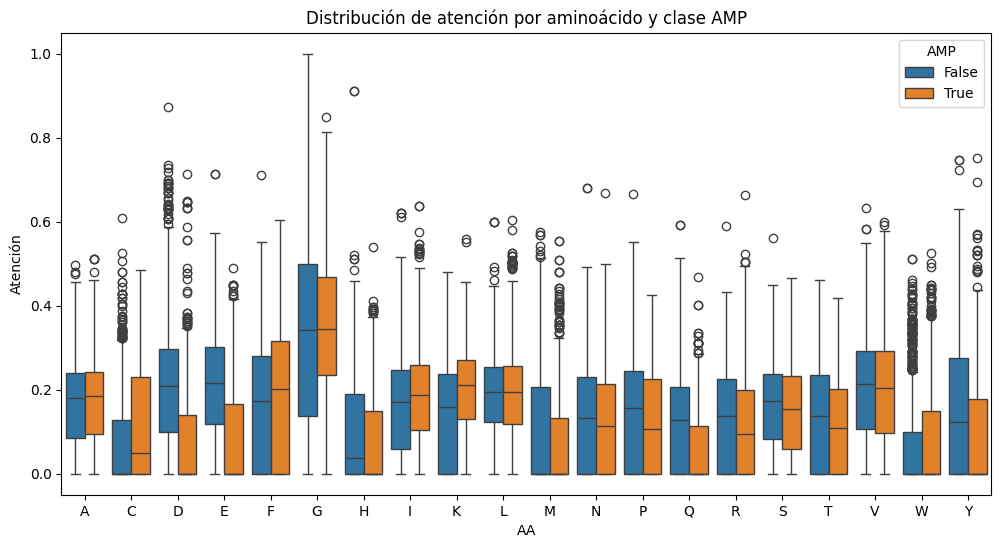

In [ ]:
# Boxplot por clase para algunos aminoácidos representativos
df_melted_rollout = df_attention_rollout.melt(id_vars='AMP', var_name='AA', value_name='Atención')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted_rollout, x='AA', y='Atención', hue='AMP')
plt.title("Distribución de atención por aminoácido y clase AMP")
plt.show()


En este caso podemos ver que los valores de atención son más elevados que para el método baseline. Notamos que la mayoría de aminoácidos apenas presentan grandes diferencias según la clase de los péptidos, aunque caben destacar los aminoácidos G, por tener los valores de atención más elevados; y los aminoácidos D y E por presentar valores más altos para los péptidos AMP.

### Diagrama de la atención media

<Axes: title={'center': 'Atención media por aminoácido con Attention rollout'}>

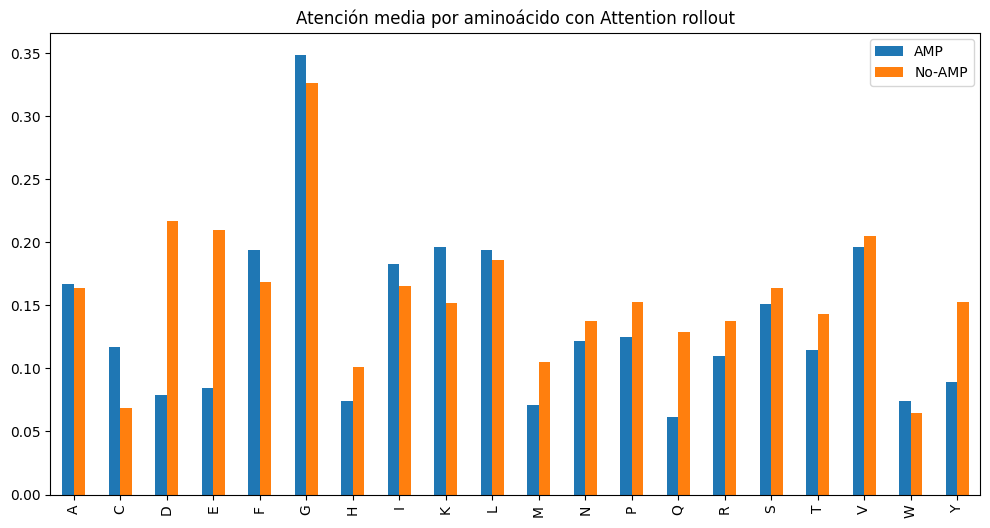

In [ ]:
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")

mean_attn_amp_rollout = df_attention_rollout[df_attention_rollout['AMP'] == True][aa_cols].mean()
mean_attn_noamp_rollout = df_attention_rollout[df_attention_rollout['AMP'] == False][aa_cols].mean()

df_means_rollout = pd.DataFrame({'AMP': mean_attn_amp_rollout, 'No-AMP': mean_attn_noamp_rollout})
df_means_rollout.plot(kind='bar', figsize=(12,6), title="Atención media por aminoácido con Attention rollout")

En este diagrama observamos un resultados similar al anterior. El aminoácido con mayor atención media es la glicina (G). Sin embargo, no existe apenas diferencia según la propiedad antimicrobiana de los péptidos.

Aquellos aminoácidos que si muestran esta diferencia son: C, D, E, Q e Y. Es decir, destacan aquellos aminoácidos que, de acuerdo con la matriz de correlaciones anterior pudimos comprobar que estaban más correlacionados con la etiqueta AMP.

### Test estadístico

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

p_values_rollout = []

for aa in aa_cols:
    grupo_AMP_rollout = df_attention_rollout[df_attention_rollout['AMP'] == True][aa]
    grupo_noAMP_rollout = df_attention_rollout[df_attention_rollout['AMP'] == False][aa]
    stat_rollout, p_rollout = mannwhitneyu(grupo_AMP_rollout, grupo_noAMP_rollout, alternative='two-sided')
    p_values_rollout.append(p_rollout)

# Corrección FDR
reject_rollout, pvals_corr_rollout, _, _ = multipletests(p_values_rollout, alpha=0.05, method='fdr_bh')

# Resultados en un dataframe
import pandas as pd
df_stats_rollout = pd.DataFrame({
    'AA': aa_cols,
    'p_value': p_values_rollout,
    'p_value_corr': pvals_corr_rollout,
    'significant': reject_rollout
}).sort_values('p_value_corr')

df_stats_rollout


,AA,p_value,p_value_corr,significant
2,D,4.474319e-95,8.948638e-94,True
3,E,3.800204e-90,3.800204e-89,True
13,Q,7.577589e-48,5.051726e-47,True
19,Y,3.879456e-19,1.939728e-18,True
8,K,7.363319e-18,2.454440e-17,True
1,C,6.737879e-18,2.454440e-17,True
10,M,7.928648e-10,2.265328e-09,True
14,R,1.815101e-09,4.537752e-09,True
16,T,1.833344e-07,4.074098e-07,True
6,H,3.102439e-07,6.204878e-07,True


En la tabla se muestran los aminoácidos ordenados según el p-valor del test Mann Whitney U. Este p-valor muestran si hay una diferencia significativa entre los valores de atención de cada aminoácido según la propiedad antimicrobiana de los péptidos.

Como podemos ver, aquellos aminoácidos que muestran dicha diferencia significativa son todos a excepción de los representados por las letras W, G, V, A y L.

### Modelos de Machine Learning

#### Regresión logística

Creamos un modelo de regresión logística para comprobar si es capaz de predecir que un péptido sea o no AMP entrenando el modelo con los valores de atención de cada aminoácido vistos desde el token de clasificación `[CLS]`.

Primero dividimos los datos en train y test haciendo una división 80/20 estratificada:

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    accuracy_score, roc_auc_score
)

# Definir columnas de péptidos
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Extraer X e y
X = df_attention_rollout[aa_cols].astype(float)
y = df_attention_rollout['AMP'].astype(int)

# Dividir en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Una vez hecha la división, entrenamos el modelo y obtenemos las métricas para el conjunto de entrenamiento y para el de validación:

In [ ]:
# Entrenar modelo
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred_train_rollout = model.predict(X_train)
y_pred_test_rollout = model.predict(X_test)
y_proba_train_rollout = model.predict_proba(X_train)[:, 1]
y_proba_test_rollout = model.predict_proba(X_test)[:, 1]

# Calcular métricas
conf_matrix_train_rollout = confusion_matrix(y_train, y_pred_train_rollout)
report_train_rollout = classification_report(y_train, y_pred_train_rollout)
f1_train_rollout = f1_score(y_train, y_pred_train_rollout)
accuracy_train_rollout = accuracy_score(y_train, y_pred_train_rollout)
roc_auc_train_rollout = roc_auc_score(y_train, y_proba_train_rollout)

conf_matrix_test_rollout = confusion_matrix(y_test, y_pred_test_rollout)
report_test_rollout = classification_report(y_test, y_pred_test_rollout)
f1_test_rollout = f1_score(y_test, y_pred_test_rollout)
accuracy_test_rollout = accuracy_score(y_test, y_pred_test_rollout)
roc_auc_test_rollout = roc_auc_score(y_test, y_proba_test_rollout)

Dibujamos las matrices de confusión de los conjuntos de train y test:

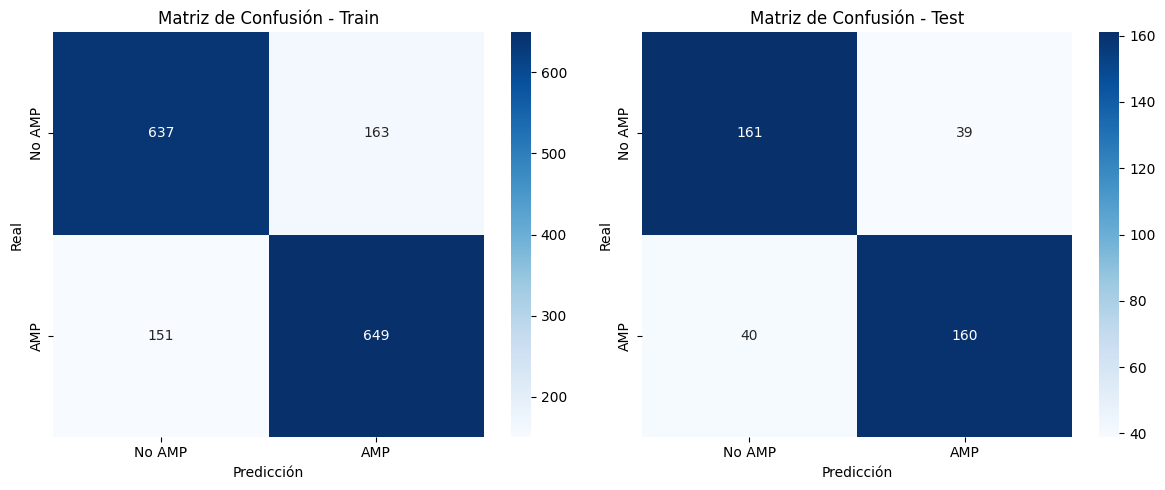

In [ ]:
# Etiquetas de clases (modifícalas si tus clases son otras)
labels = ['No AMP', 'AMP']

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión - Train
sns.heatmap(conf_matrix_train_rollout, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Matriz de Confusión - Train')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Matriz de confusión - Test
sns.heatmap(conf_matrix_test_rollout, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Matriz de Confusión - Test')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

Observamos que en ambos casos parece que obtenemos resultados similares y que las predicciones son buenas. En su mayoría, la regresión logística logra acertar la predicción de los péptidos usando como referencia los valores de atención del modelo basado en transformers, aunque parece que le es más complicado predecir los péptidos que son AMP. Veamos los valores de las diferentes métricas:

In [ ]:
# Mostrar resultados
print("Métricas del conjunto de entrenamiento:")
print(report_train_rollout)
print("\nMétricas del conjunto de test:")
print(report_test_rollout)


Métricas del conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       800
           1       0.80      0.81      0.81       800

    accuracy                           0.80      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.80      0.80      0.80      1600


Métricas del conjunto de test:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       200
           1       0.80      0.80      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



Como podemos observar, los resultados obtenidos son prácticamente idéntidos para los conjuntos de entrenamiento y de test, siendo estos, de hecho, bastante buenos.

Veamos ahora las curvas ROC:

Observamos que el valor

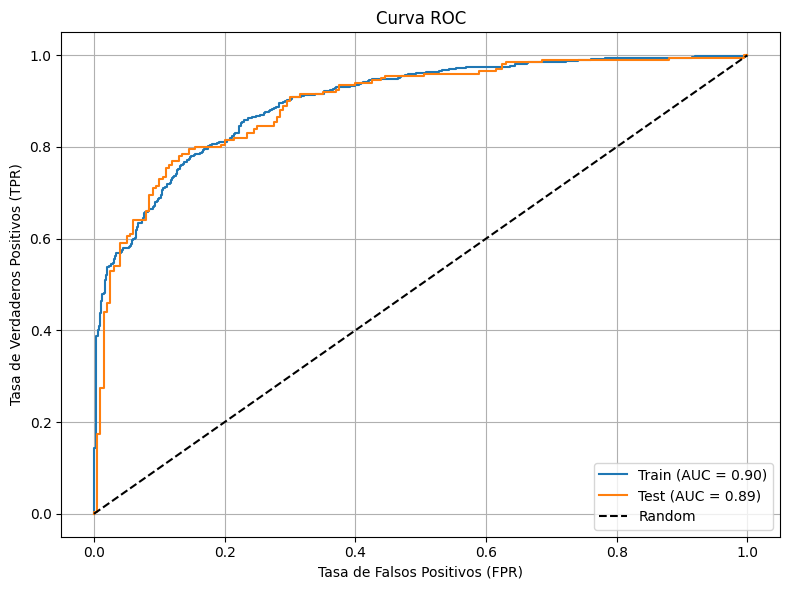

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcular curvas ROC
fpr_train_rollout, tpr_train_rollout, _ = roc_curve(y_train, y_proba_train_rollout)
fpr_test_rollout, tpr_test_rollout, _ = roc_curve(y_test, y_proba_test_rollout)

# Dibujar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_rollout, tpr_train_rollout, label=f'Train (AUC = {roc_auc_train_rollout:.2f})')
plt.plot(fpr_test_rollout, tpr_test_rollout, label=f'Test (AUC = {roc_auc_test_rollout:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


De acuerdo con estas dos curvas, la regresión logística parece hacer buenas predicciones tanto para los conjuntos de entrenamiento y de test.

30 minutos de ejecución

# Attention Flow



El último método de explicabilidad que vamos a aplicar es Attention Flow. A continuación, se muestran los detalles y sus resultados:

### Funciones auxiliares para obtener los vectores de atención

Definimos unas funciones auxiliares para obtener el vector de atención desde el token `[CLS]` de la última capa de cada péptido:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Usamos el tokenizador de AMPBERT original
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd")
# Y el modelo fine-tuneado que te pasaron
model = BertForSequenceClassification.from_pretrained("alexcis95/amp_bert_rep", output_attentions=True)

In [ ]:
def get_inputs_from_sequence(sequence):
    # Tokenizar secuencia de proteína
    sequence = " ".join(sequence)  # Espacios entre aminoácidos
    inputs = tokenizer(sequence, return_tensors="pt")
    return inputs

import torch


def compute_attention_flow(attentions):
    # Inicializar con matriz de atención promedio de la última capa
    flow = attentions[-1].mean(dim=1).squeeze(0)  # Última capa, promedio sobre cabezas

    # Propagar hacia atrás multiplicando por las capas anteriores (sin identidad ni normalización)
    for attention in reversed(attentions[:-1]):
        attention_heads_fused = attention.mean(dim=1).squeeze(0)
        flow = torch.matmul(attention_heads_fused, flow)

    return flow

def get_attention_flow_result_from_CLS(sequence):
    inputs = get_inputs_from_sequence(sequence)

    # Pasar la secuencia por el modelo
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Lista de tensores de atención por capa

    attention_flow = compute_attention_flow(attentions)

    return attention_flow[1:-1,1:-1][0]

### Obtención de los vectores

A continuación, procedemos a la obtención de todos los vectores de atención usando las funciones auxiliares anteriores. Para ello, vamos a iterar sobre nuestro conjunto de datos `muestra`, que contiene mil péptidos no AMP y mil AMP.

Como hemos comentado anteriormente, obtenemos los vectores de atención de estos péptidos para estudiar los péptidos de cada proteína que reciben más atención por parte del token de clasificación `CLS` para realizar la predicción.

In [ ]:
vectores_atencion_flow = []

# Recorremos todas las proteínas que hemos tomado como muestra
for index, row in muestra.iterrows():
  #Obtenemos el vector de atención
  v_atencion = get_attention_flow_result_from_CLS(row['aa_seq'])

  # Guardamos el vector de atención en la lista "vectores_atencion"
  vectores_atencion_flow.append(v_atencion)


Normalizamos como siempre:

In [ ]:
all_attention_values = torch.cat(vectores_atencion_flow)
global_min = all_attention_values.min()
global_max = all_attention_values.max()

vectores_atencion_flow_norm = []
for v in vectores_atencion_flow:
    if global_max > global_min:
        v_norm = (v - global_min) / (global_max - global_min)
    else:
        v_norm = torch.zeros_like(v)
    vectores_atencion_flow_norm.append(v_norm)

Ahora creamos una lista de diccionarios. Cada diccionario de la lista se corresponde con una de los péptidos para las cuales hemos calculado los vectores de atención. Todos los diccionarios tienen como claves a los posibles péptidos de cualquier péptido, y los valores de cada una de las claves son cero si ese péptido no aparece en el péptido y, en caso de estar, el valor máximo del vector de atención de el péptido en cuestión.

In [ ]:
# Aminoácidos estándar
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Creamos un diccionario por proteína
protein_attention_dicts_rollout = []

proteinas = muestra['aa_seq'].str.replace(' ', '')

for seq, att in zip(proteinas, vectores_atencion_flow_norm):
    attention_dict = dict.fromkeys(amino_acids, 0.0)
    for aa, value in zip(seq, att):
        if value.item() > attention_dict[aa]:
            attention_dict[aa] = value.item()
    protein_attention_dicts_rollout.append(attention_dict)


'''
# Resultado: lista de diccionarios
for i, d in enumerate(protein_attention_dicts):
    print(f"Proteína {i+1}:")
    print(d)
'''



'\n# Resultado: lista de diccionarios\nfor i, d in enumerate(protein_attention_dicts):\n    print(f"Proteína {i+1}:")\n    print(d)\n'

Convertimos el diccionario en un DataFrame de pandas:

In [ ]:
df_attention_flow = pd.DataFrame(protein_attention_dicts_rollout)
df_attention_flow['AMP'] = muestra['AMP']
df_attention_flow

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,AMP
0,0.000000,0.000000,0.131437,0.112923,0.000000,0.169810,0.000000,0.000000,0.000000,0.000000,...,0.161915,0.127473,0.178244,0.104633,0.166386,0.170677,0.143807,0.000000,0.000000,False
1,0.098933,0.068583,0.102111,0.117654,0.000000,0.110746,0.000000,0.000000,0.086733,0.000000,...,0.000000,0.117301,0.096033,0.102996,0.119698,0.063755,0.000000,0.000000,0.000000,False
2,0.072917,0.000000,0.040259,0.032200,0.040076,0.062608,0.026422,0.019798,0.016491,0.039616,...,0.010931,0.045236,0.027046,0.046887,0.034497,0.030097,0.050876,0.000000,0.000000,False
3,0.130443,0.000000,0.120874,0.109993,0.000000,0.101329,0.000000,0.000000,0.000000,0.115952,...,0.000000,0.103100,0.133946,0.111990,0.000000,0.105024,0.095597,0.000000,0.000000,False
4,0.074001,0.040414,0.103995,0.089559,0.048788,0.090654,0.000000,0.076029,0.091826,0.088556,...,0.082124,0.000000,0.000000,0.089112,0.067165,0.096253,0.102767,0.072249,0.075583,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.147116,0.000000,0.000000,0.000000,0.099914,0.186063,0.000000,0.162893,0.205386,0.149642,...,0.173330,0.000000,0.000000,0.000000,0.170357,0.145545,0.000000,0.000000,0.000000,True
1996,0.115377,0.126409,0.000000,0.000000,0.113381,0.085349,0.000000,0.140989,0.164871,0.150980,...,0.000000,0.163062,0.000000,0.151976,0.147624,0.000000,0.000000,0.000000,0.000000,True
1997,0.098408,0.000000,0.081279,0.056854,0.048142,0.101089,0.084015,0.106690,0.107077,0.073761,...,0.084507,0.121893,0.081779,0.000000,0.000000,0.000000,0.036475,0.000000,0.000000,True
1998,0.139554,0.000000,0.000000,0.000000,0.141435,0.134970,0.162270,0.000000,0.181089,0.000000,...,0.138969,0.000000,0.000000,0.000000,0.131922,0.179486,0.102944,0.000000,0.000000,True


In [ ]:
# Guardar
df_attention_flow.to_parquet("attention_flow.parquet")

from google.colab import files
files.download("attention_flow.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cargar
df_attention_flow = pd.read_parquet("attention_flow.parquet")

## Análisis exploratorio de los datos

Vamos a realizar el análisis exploratorio de los datos. Empezamos con la matriz de correlación de los valores de atención de los *aminoácidos*:

### Matriz de correlaciones

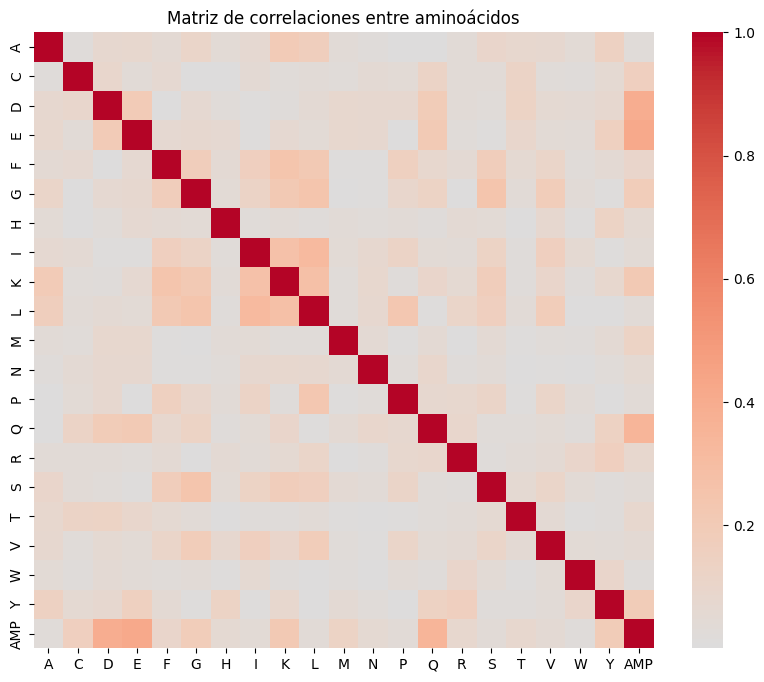

In [ ]:
correlation_matrix_flow = df_attention_flow.corr()
correlation_matrix_abs_flow = correlation_matrix_flow.abs()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_abs_flow, cmap='coolwarm', center=0)
plt.title("Matriz de correlaciones entre aminoácidos")
plt.show()

En la matriz de correlaciones vamos a fijarnos en la última fila. En ella podemos ver la correlación entre la etiqueta AMP y cada uno de los aminoácidos. Como podemos comprobar, los aminoácidos más correlacionados con la predicción son los representados por las letras C, D, E, G, K, Q e Y.

### Diagrama de cajas

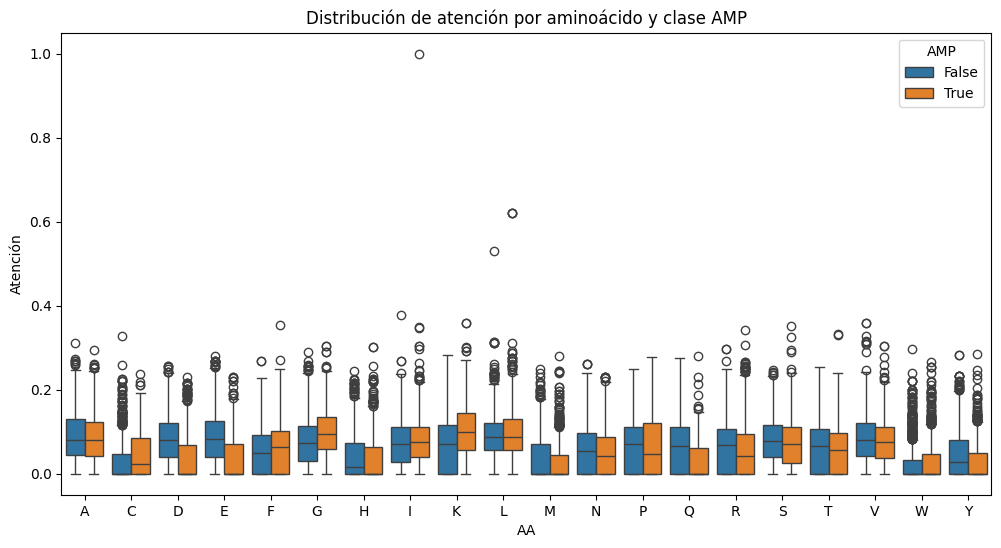

In [ ]:
# Boxplot por clase para algunos aminoácidos representativos
df_melted_flow = df_attention_flow.melt(id_vars='AMP', var_name='AA', value_name='Atención')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted_flow, x='AA', y='Atención', hue='AMP')
plt.title("Distribución de atención por aminoácido y clase AMP")
plt.show()


En este caso, apenas hay diferencias en los valores de atención obtenidos para los diferentes aminoácidos. En este caso, los aminoácidos que parece presentar diferencias, aunque no muy grandes, en las distribuciones de los valores de atención según la clase de los péptidso, son los aminoácidos D y E, teniendo valores más elevados para los péptidos no AMP; y C, siendo los valores más elevados los de los péptidos AMP.

### Diagrama de la atención media

<Axes: title={'center': 'Atención media por aminoácido con Attention Flow'}>

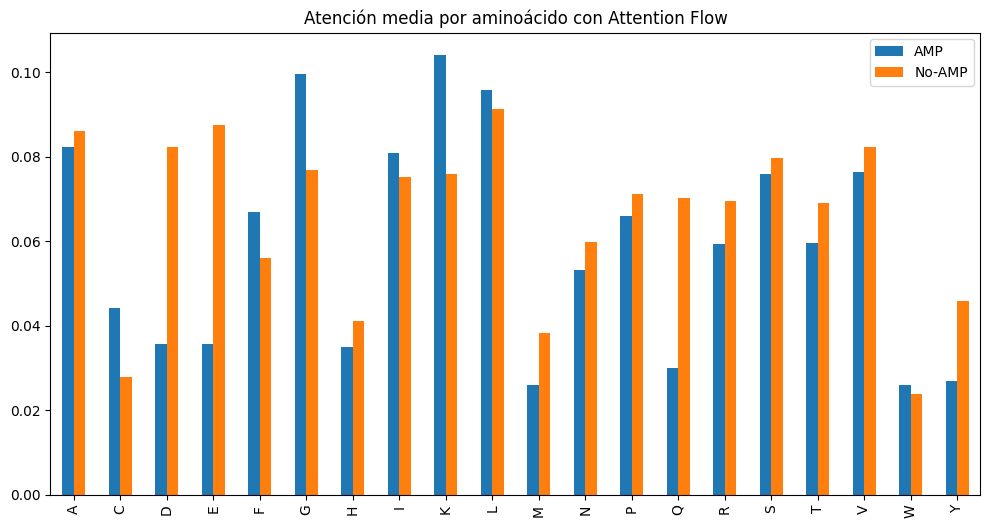

In [ ]:
aa_cols = list("ACDEFGHIKLMNPQRSTVWY")

mean_attn_amp_flow = df_attention_flow[df_attention_flow['AMP'] == True][aa_cols].mean()
mean_attn_noamp_flow = df_attention_flow[df_attention_flow['AMP'] == False][aa_cols].mean()

df_means_flow = pd.DataFrame({'AMP': mean_attn_amp_flow, 'No-AMP': mean_attn_noamp_flow})
df_means_flow.plot(kind='bar', figsize=(12,6), title="Atención media por aminoácido con Attention Flow")

En este diagrama observamos un resultado similar al anterior. Los aminoácidos que presentan diferencias en la media de los valores de atención son los aminoácidos D, E e Y, siendo más elevados los valores para la clase no AMP; y C, G y K, siendo mayores los valores para la clase AMP.

### Test estadístico

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

p_values_flow = []

for aa in aa_cols:
    grupo_AMP_flow = df_attention_flow[df_attention_flow['AMP'] == True][aa]
    grupo_noAMP_flow = df_attention_flow[df_attention_flow['AMP'] == False][aa]
    stat_flow, p_flow = mannwhitneyu(grupo_AMP_flow, grupo_noAMP_flow, alternative='two-sided')
    p_values_flow.append(p_flow)

# Corrección FDR
reject_flow, pvals_corr_flow, _, _ = multipletests(p_values_flow, alpha=0.05, method='fdr_bh')

# Resultados en un dataframe
import pandas as pd
df_stats_flow = pd.DataFrame({
    'AA': aa_cols,
    'p_value': p_values_flow,
    'p_value_corr': pvals_corr_flow,
    'significant': reject_flow
}).sort_values('p_value_corr')

df_stats_flow


,AA,p_value,p_value_corr,significant
3,E,2.171006e-81,4.342012e-80,True
2,D,1.349916e-76,1.349916e-75,True
13,Q,1.477382e-52,9.849212e-52,True
8,K,6.087054e-21,3.043527e-20,True
19,Y,7.064360e-18,2.825744e-17,True
5,G,3.394597e-17,1.131532e-16,True
1,C,1.051471e-15,3.004204e-15,True
10,M,1.386256e-09,3.465640e-09,True
14,R,4.588899e-08,1.019755e-07,True
6,H,3.527389e-05,7.054778e-05,True


En la tabla se muestran los aminoácidos ordenados según el p-valor del test Mann Whitney U. Este p-valor muestran si hay una diferencia significativa entre los valores de atención de cada aminoácido según la propiedad antimicrobiana de los péptidos.

Como podemos ver, aquellos aminoácidos que muestran dicha diferencia significativa, es decir, aquellos aminoácidos que parecen influir en la propiedad antimicrobiana de los péptidos son todos a excepción de los aminoácidos I, S, V, W, A y L.

### Modelos de Machine Learning

#### Regresión logística

Creamos un modelo de regresión logística para comprobar si es capaz de predecir que un péptido sea o no AMP entrenando el modelo con los valores de atención de cada aminoácido vistos desde el token de clasificación `[CLS]`.

Primero dividimos los datos en train y test haciendo una división 80/20 estratificada:

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    accuracy_score, roc_auc_score
)

# Definir columnas de péptidos
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Extraer X e y
X = df_attention_flow[aa_cols].astype(float)
y = df_attention_flow['AMP'].astype(int)

# Dividir en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Una vez hecha la división, entrenamos el modelo y obtenemos las métricas para el conjunto de entrenamiento y para el de validación:

In [ ]:
# Entrenar modelo
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred_train_flow = model.predict(X_train)
y_pred_test_flow = model.predict(X_test)
y_proba_train_flow = model.predict_proba(X_train)[:, 1]
y_proba_test_flow = model.predict_proba(X_test)[:, 1]

# Calcular métricas
conf_matrix_train_flow = confusion_matrix(y_train, y_pred_train_flow)
report_train_flow = classification_report(y_train, y_pred_train_flow)
f1_train_flow = f1_score(y_train, y_pred_train_flow)
accuracy_train_flow = accuracy_score(y_train, y_pred_train_flow)
roc_auc_train_flow = roc_auc_score(y_train, y_proba_train_flow)

conf_matrix_test_flow = confusion_matrix(y_test, y_pred_test_flow)
report_test_flow = classification_report(y_test, y_pred_test_flow)
f1_test_flow = f1_score(y_test, y_pred_test_flow)
accuracy_test_flow = accuracy_score(y_test, y_pred_test_flow)
roc_auc_test_flow = roc_auc_score(y_test, y_proba_test_flow)

Dibujamos las matrices de confusión de los conjuntos de train y test:

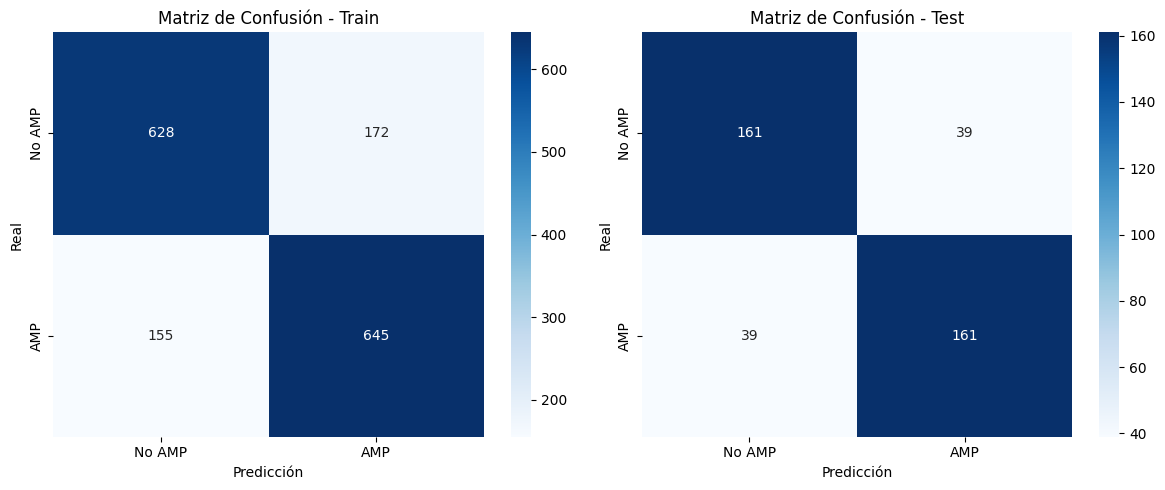

In [ ]:
# Etiquetas de clases (modifícalas si tus clases son otras)
labels = ['No AMP', 'AMP']

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión - Train
sns.heatmap(conf_matrix_train_flow, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Matriz de Confusión - Train')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Matriz de confusión - Test
sns.heatmap(conf_matrix_test_flow, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Matriz de Confusión - Test')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

Observamos que en ambos casos parece que obtenemos resultados similares y que las predicciones son buenas. En su mayoría, la regresión logística logra acertar la predicción de los péptidos usando como referencia los valores de atención del modelo basado en transformers, aunque parece que le es más complicado predecir los péptidos que son AMP. Veamos los valores de las diferentes métricas:

In [ ]:
# Mostrar resultados
print("Métricas del conjunto de entrenamiento:")
print(report_train_flow)
print("\nMétricas del conjunto de test:")
print(report_test_flow)


Métricas del conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       800
           1       0.79      0.81      0.80       800

    accuracy                           0.80      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.80      0.80      0.80      1600


Métricas del conjunto de test:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       200
           1       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



Nuevamente, los valores de las métricas de los conjuntos de entrenamiento y validación son muy similares entre sí y altos, por lo que parece que hemos obtenido un buen modelo de regresión logística.

Veamos ahora las curvas ROC:

Observamos que el valor

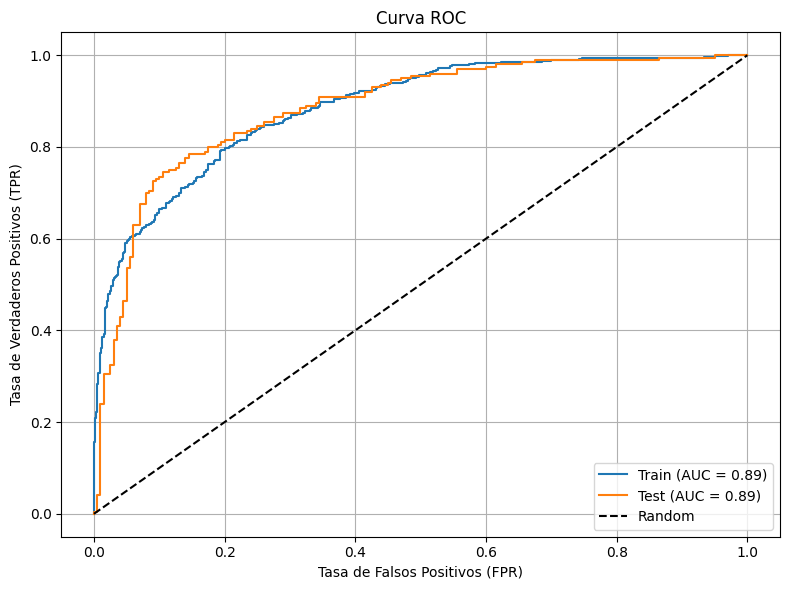

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcular curvas ROC
fpr_train_flow, tpr_train_flow, _ = roc_curve(y_train, y_proba_train_flow)
fpr_test_flow, tpr_test_flow, _ = roc_curve(y_test, y_proba_test_flow)

# Dibujar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_flow, tpr_train_flow, label=f'Train (AUC = {roc_auc_train_flow:.2f})')
plt.plot(fpr_test_flow, tpr_test_flow, label=f'Test (AUC = {roc_auc_test_flow:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Como siempre, los valores de las curvas son muy buenos, por lo que el modelo de regresión logística parece ser bueno.

# Comparamos los tres métodos

### Matrices de correlaciones

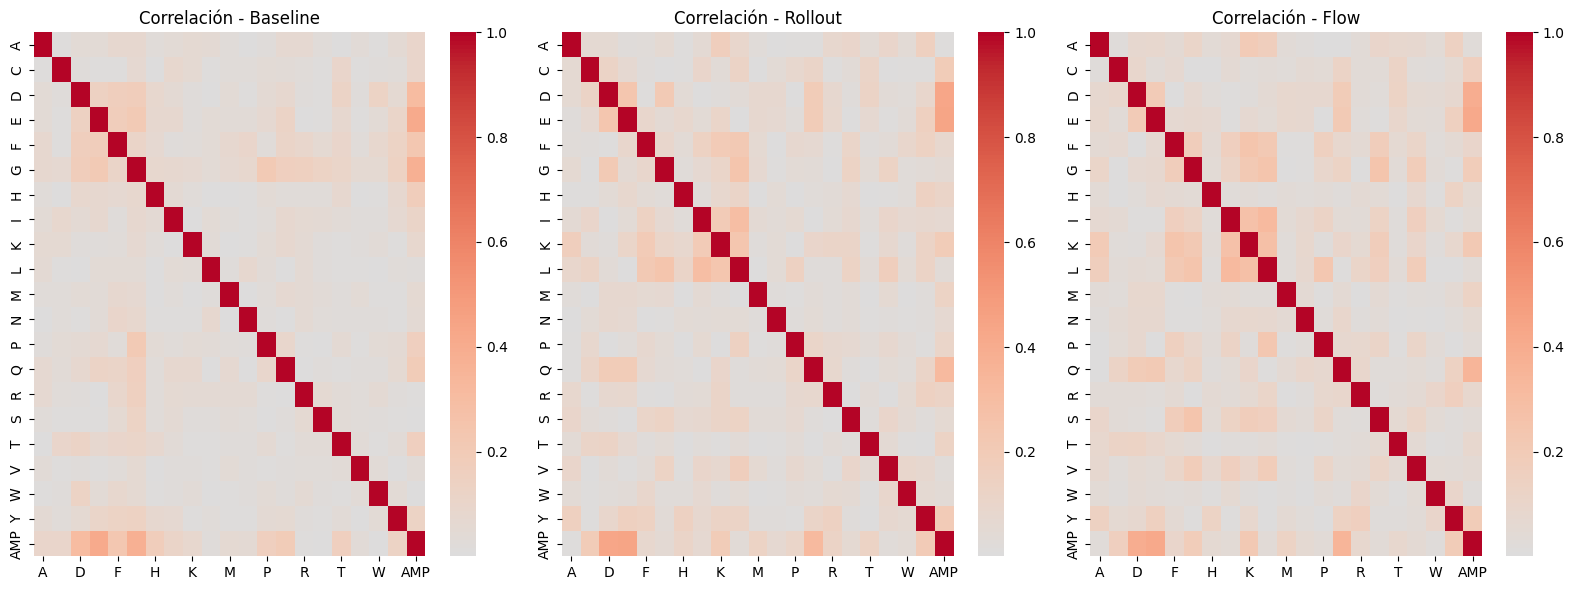

In [ ]:
# Crear la figura y los ejes: 1 fila, 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(16, 6))  # ajusta el tamaño según necesidad

# Primer heatmap: rollout
sns.heatmap(correlation_matrix_abs_baseline, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title("Correlación - Baseline")

# Primer heatmap: rollout
sns.heatmap(correlation_matrix_abs_rollout, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title("Correlación - Rollout")

# Segundo heatmap: flow
sns.heatmap(correlation_matrix_abs_flow, cmap='coolwarm', center=0, ax=axes[2])
axes[2].set_title("Correlación - Flow")

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()

Observamos que las matrices de correlación de los métodos Attention Rollout y Attention Flow son muy similares y mayores que los obtenidos para el método base. Además, los aminoácidos con mayor correlación con la etiqueta AMP coinciden entre los métodos Attention Rollout y Attention Flow. El método baseline muestra ligeras diferencias con los otros dos.

### Diagramas de cajas

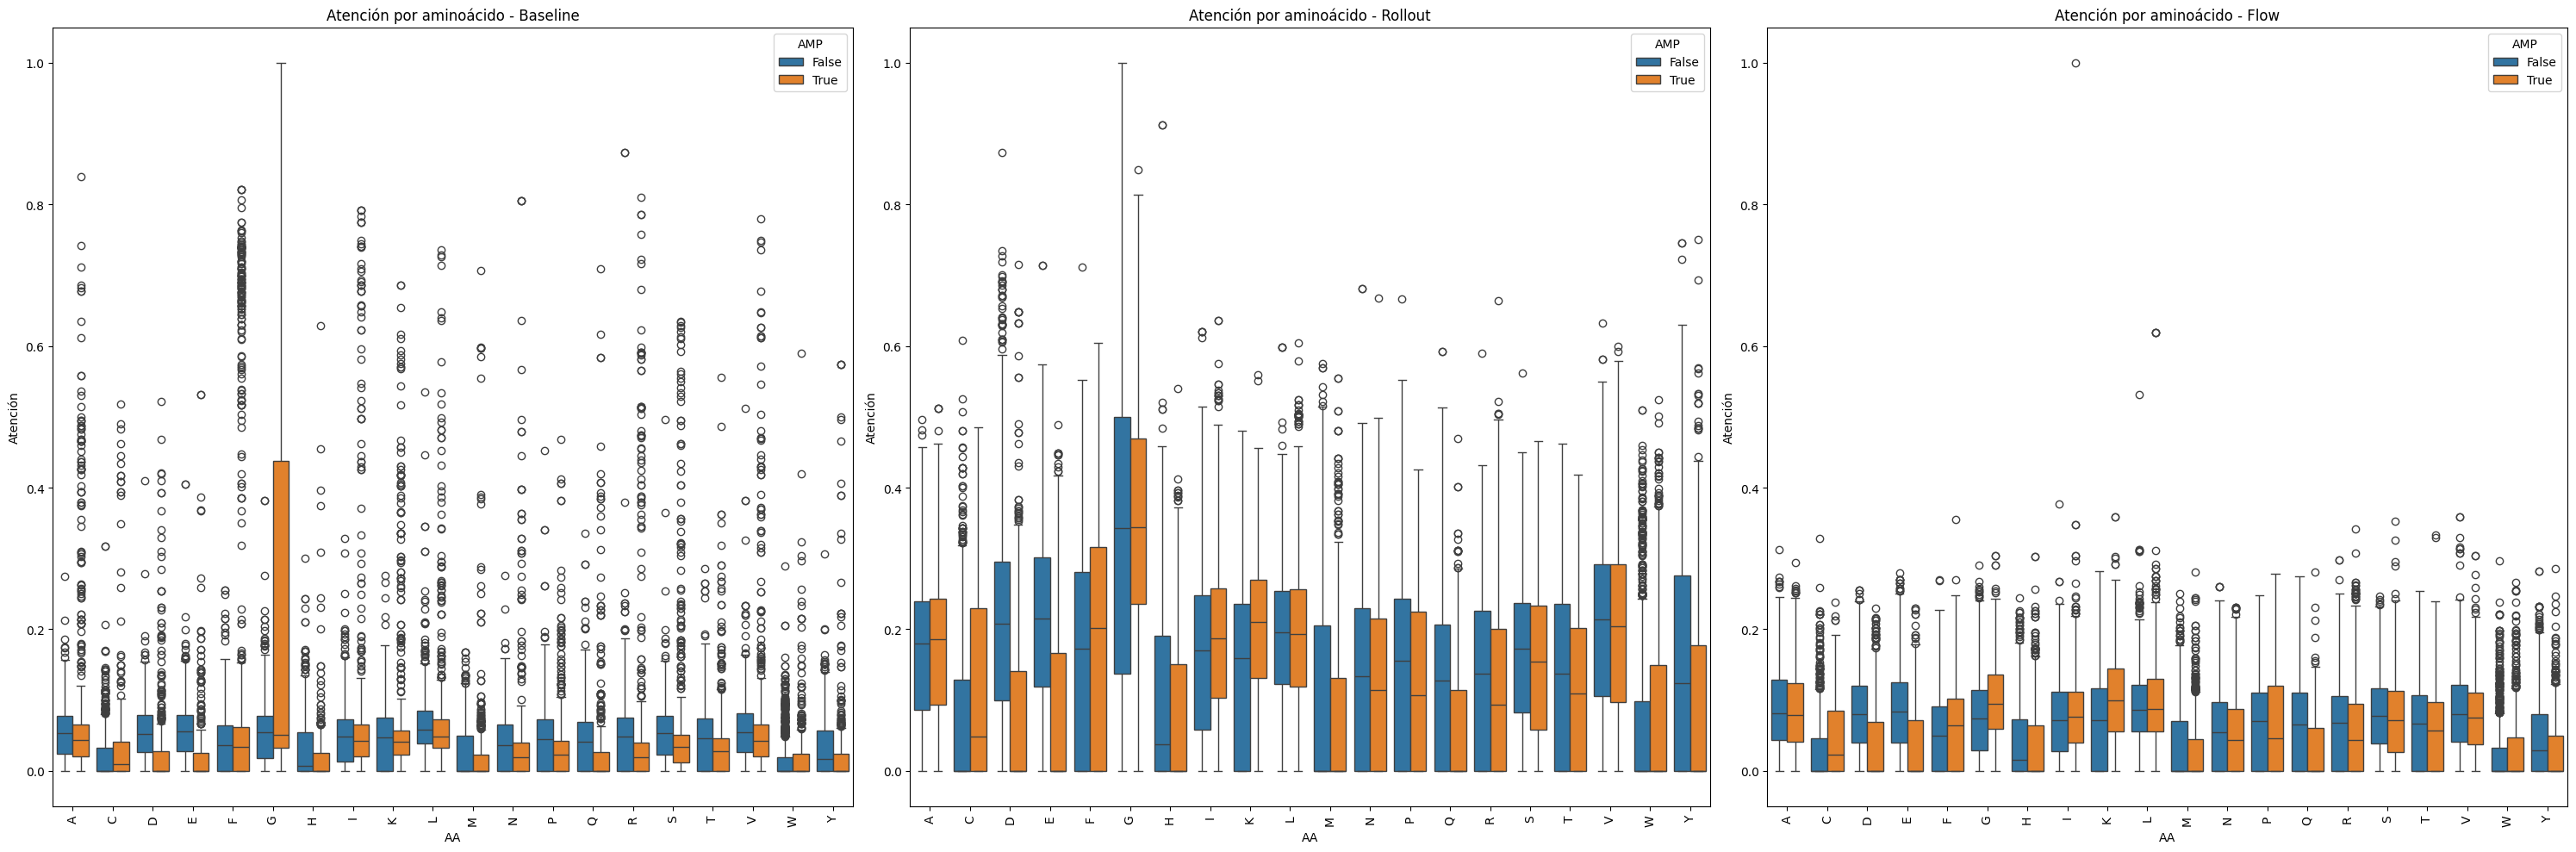

In [ ]:
# Crear la figura con dos subgráficos en una fila
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Ajusta el tamaño si lo necesitas

# Boxplot para df_melted_baseline
sns.boxplot(data=df_melted_baseline, x='AA', y='Atención', hue='AMP', ax=axes[0])
axes[0].set_title("Atención por aminoácido - Baseline")
axes[0].tick_params(axis='x', rotation=90)  # Rota etiquetas si son muchas

# Boxplot para df_melted_rollout
sns.boxplot(data=df_melted_rollout, x='AA', y='Atención', hue='AMP', ax=axes[1])
axes[1].set_title("Atención por aminoácido - Rollout")
axes[1].tick_params(axis='x', rotation=90)  # Rota etiquetas si son muchas

# Boxplot para df_melted_flow
sns.boxplot(data=df_melted_flow, x='AA', y='Atención', hue='AMP', ax=axes[2])
axes[2].set_title("Atención por aminoácido - Flow")
axes[2].tick_params(axis='x', rotation=90)

# Ajuste de layout
plt.tight_layout()
plt.show()

Se puede observar que el método que obtiene los valores de atención más elevados es, con diferencia Attention Rollout. Los métodos Attention Flow y baseline presentan resultados similares, aunque en el método base destaca la distribución del aminoácido G para los péptidos AMP.

Además, notamos que hay similitudes con los aminoácidos que presentan valores mayores para la clase no AMP y para para la clase AMP para los tres métodos. En los tres destacan los aminoácidos D, E e Y para la clase no AMP.

### Diagramas de la atención media

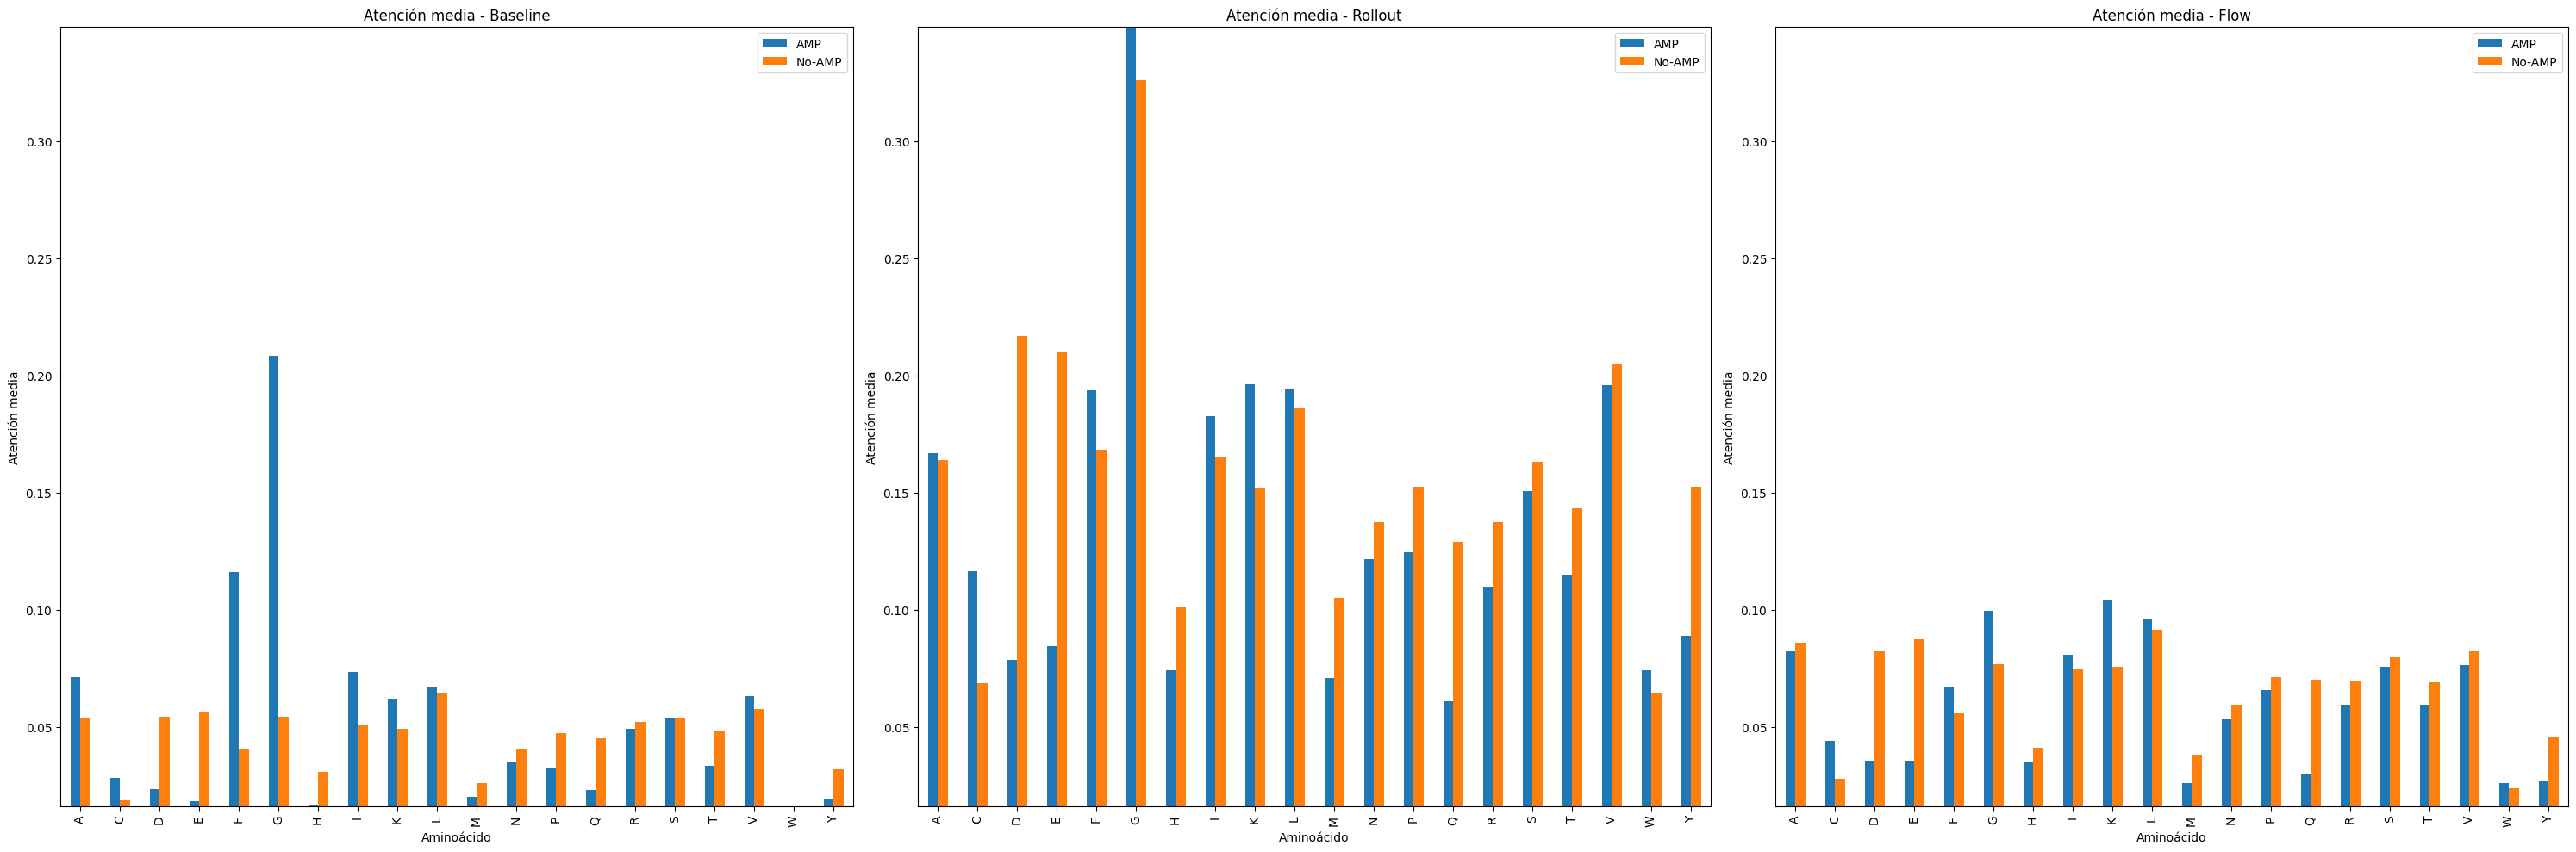

In [ ]:
import matplotlib.pyplot as plt

# Calcular límites comunes del eje Y
global_min = min(df.min().min() for df in [df_means_baseline, df_means_rollout, df_means_flow])
global_max = max(df.max().max() for df in [df_means_baseline, df_means_rollout, df_means_flow])

# Crear la figura con tres subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Barplot para baseline
df_means_baseline.plot(kind='bar', ax=axes[0], title="Atención media - Baseline")
axes[0].set_ylabel("Atención media")
axes[0].set_xlabel("Aminoácido")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylim(global_min, global_max)

# Barplot para rollout
df_means_rollout.plot(kind='bar', ax=axes[1], title="Atención media - Rollout")
axes[1].set_ylabel("Atención media")
axes[1].set_xlabel("Aminoácido")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylim(global_min, global_max)

# Barplot para flow
df_means_flow.plot(kind='bar', ax=axes[2], title="Atención media - Flow")
axes[2].set_ylabel("Atención media")
axes[2].set_xlabel("Aminoácido")
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_ylim(global_min, global_max)

# Ajuste del diseño
plt.tight_layout()
plt.show()


Al igual que en la comparativa anterior, el método que ofrece resultados más elevados es Attention Rolllout, seguido del método base -principalmente por el aminoácido G- y del método Attention Flow.

Se observan en este diagrama, al igual que en el anterior, similitudes entre los aminoácidos que presentan medias diferentes entre las dos clases (D, E e Y para la clase no AMP).

### Tests estadísticos

In [ ]:
# Renombrar explícitamente para evitar conflictos tras los merges
df_baseline = df_stats_baseline[['AA', 'significant']].rename(columns={'significant': 'significant_baseline'})
df_rollout = df_stats_rollout[['AA', 'significant']].rename(columns={'significant': 'significant_rollout'})
df_flow = df_stats_flow[['AA', 'significant']].rename(columns={'significant': 'significant_flow'})

# Merge paso a paso
merged_stats = pd.merge(df_baseline, df_rollout, on='AA')
merged_stats = pd.merge(merged_stats, df_flow, on='AA')

# 1. Comunes con significancia True en todos
common_true = merged_stats[
    (merged_stats['significant_baseline']) &
    (merged_stats['significant_rollout']) &
    (merged_stats['significant_flow'])
]

# 2. Comunes con significancia False en todos
common_false = merged_stats[
    (~merged_stats['significant_baseline']) &
    (~merged_stats['significant_rollout']) &
    (~merged_stats['significant_flow'])
]

def highlight_differences(row):
    if row['significant_baseline'] and row['significant_rollout'] and row['significant_flow']:
        return ['background-color: lightgreen'] * 3
    elif not row['significant_baseline'] and not row['significant_rollout'] and not row['significant_flow']:
        return ['background-color: lightgray'] * 3
    else:
        return ['background-color: lightcoral'] * 3

styled = merged_stats.style.apply(highlight_differences, axis=1, subset=['significant_baseline', 'significant_rollout', 'significant_flow'])
styled.set_caption("Comparación de significancia entre Baseline, Rollout y Flow")

styled


,AA,significant_baseline,significant_rollout,significant_flow
0,E,True,True,True
1,D,True,True,True
2,Q,True,True,True
3,R,True,True,True
4,T,True,True,True
5,Y,True,True,True
6,P,True,True,True
7,S,True,True,False
8,H,True,True,True
9,N,True,True,True


En verde se observan los aminoácidos que presentan diferencias significativas en los tres métodos entre las dos clases de péptidos; en gris, aquellos que no presentan diferencias significativas para ningún método; y en rojo tenemos aquellos que presentan discrepancias.

Como se puede observar hay discrepancias con los aminoácidos S, G, V, L, A, I y F, y en algunos casos coincide el método baseline con alguno de los dos, o bien coinciden los métodos Attention Rollout y Flow entre sí.

### Modelos de Machine Learning


#### Regresión logística

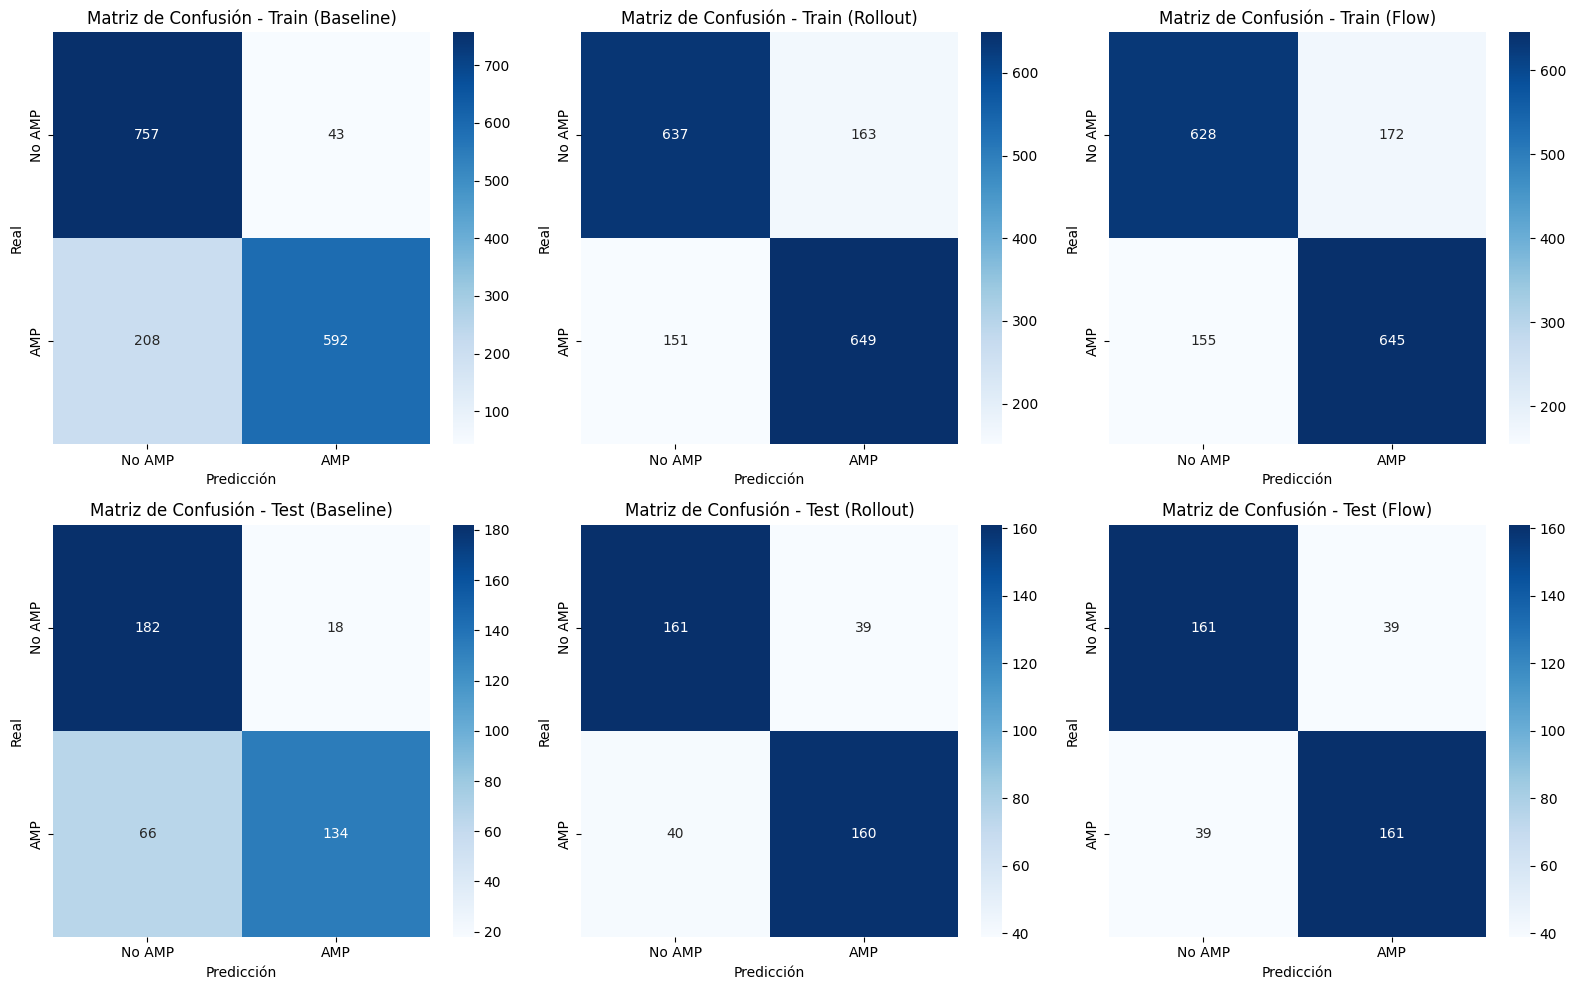

In [ ]:
# Crear figura con 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# --- Primera fila: Train ---

# Matriz de confusión - Train (Baseline)
sns.heatmap(conf_matrix_train_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0, 0])
axes[0, 0].set_title('Matriz de Confusión - Train (Baseline)')
axes[0, 0].set_xlabel('Predicción')
axes[0, 0].set_ylabel('Real')

# Matriz de confusión - Train (Rollout)
sns.heatmap(conf_matrix_train_rollout, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0, 1])
axes[0, 1].set_title('Matriz de Confusión - Train (Rollout)')
axes[0, 1].set_xlabel('Predicción')
axes[0, 1].set_ylabel('Real')

# Matriz de confusión - Train (Flow)
sns.heatmap(conf_matrix_train_flow, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0, 2])
axes[0, 2].set_title('Matriz de Confusión - Train (Flow)')
axes[0, 2].set_xlabel('Predicción')
axes[0, 2].set_ylabel('Real')

# --- Segunda fila: Test ---

# Matriz de confusión - Test (Baseline)
sns.heatmap(conf_matrix_test_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1, 0])
axes[1, 0].set_title('Matriz de Confusión - Test (Baseline)')
axes[1, 0].set_xlabel('Predicción')
axes[1, 0].set_ylabel('Real')

# Matriz de confusión - Test (Rollout)
sns.heatmap(conf_matrix_test_rollout, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1, 1])
axes[1, 1].set_title('Matriz de Confusión - Test (Rollout)')
axes[1, 1].set_xlabel('Predicción')
axes[1, 1].set_ylabel('Real')

# Matriz de confusión - Test (Flow)
sns.heatmap(conf_matrix_test_flow, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1, 2])
axes[1, 2].set_title('Matriz de Confusión - Test (Flow)')
axes[1, 2].set_xlabel('Predicción')
axes[1, 2].set_ylabel('Real')

# Ajustar espacios
plt.tight_layout()
plt.show()

Las matrices de confusión muestran que los métodso Atttention Flow y Attention Rollout presentan resultados muy similares y mejores que el método baseline.

In [ ]:
print("Métricas del conjunto de entrenamiento (baseline):")
print(report_train_baseline)
print("Métricas del conjunto de entrenamiento (rollout):")
print(report_train_rollout)
print("Métricas del conjunto de entrenamiento (flow):")
print(report_train_flow)
print("\nMétricas del conjunto de test (baseline):")
print(report_test_baseline)
print("\nMétricas del conjunto de test (rollout):")
print(report_test_rollout)
print("\nMétricas del conjunto de test (flow):")
print(report_test_flow)

Métricas del conjunto de entrenamiento (baseline):
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       800
           1       0.93      0.74      0.83       800

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600

Métricas del conjunto de entrenamiento (rollout):
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       800
           1       0.80      0.81      0.81       800

    accuracy                           0.80      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.80      0.80      0.80      1600

Métricas del conjunto de entrenamiento (flow):
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       800
           1       0.79      0.81      0.80       800

    accuracy                      

Los valores de las métricas coinciden con lo expuesto anteriormente, con la salvedad de que hay que destacar que para Attention Rollout y Attention Flow, tenemos resultados muy parecidos entre los conjuntos de validación y de test y entre los dos métodos.

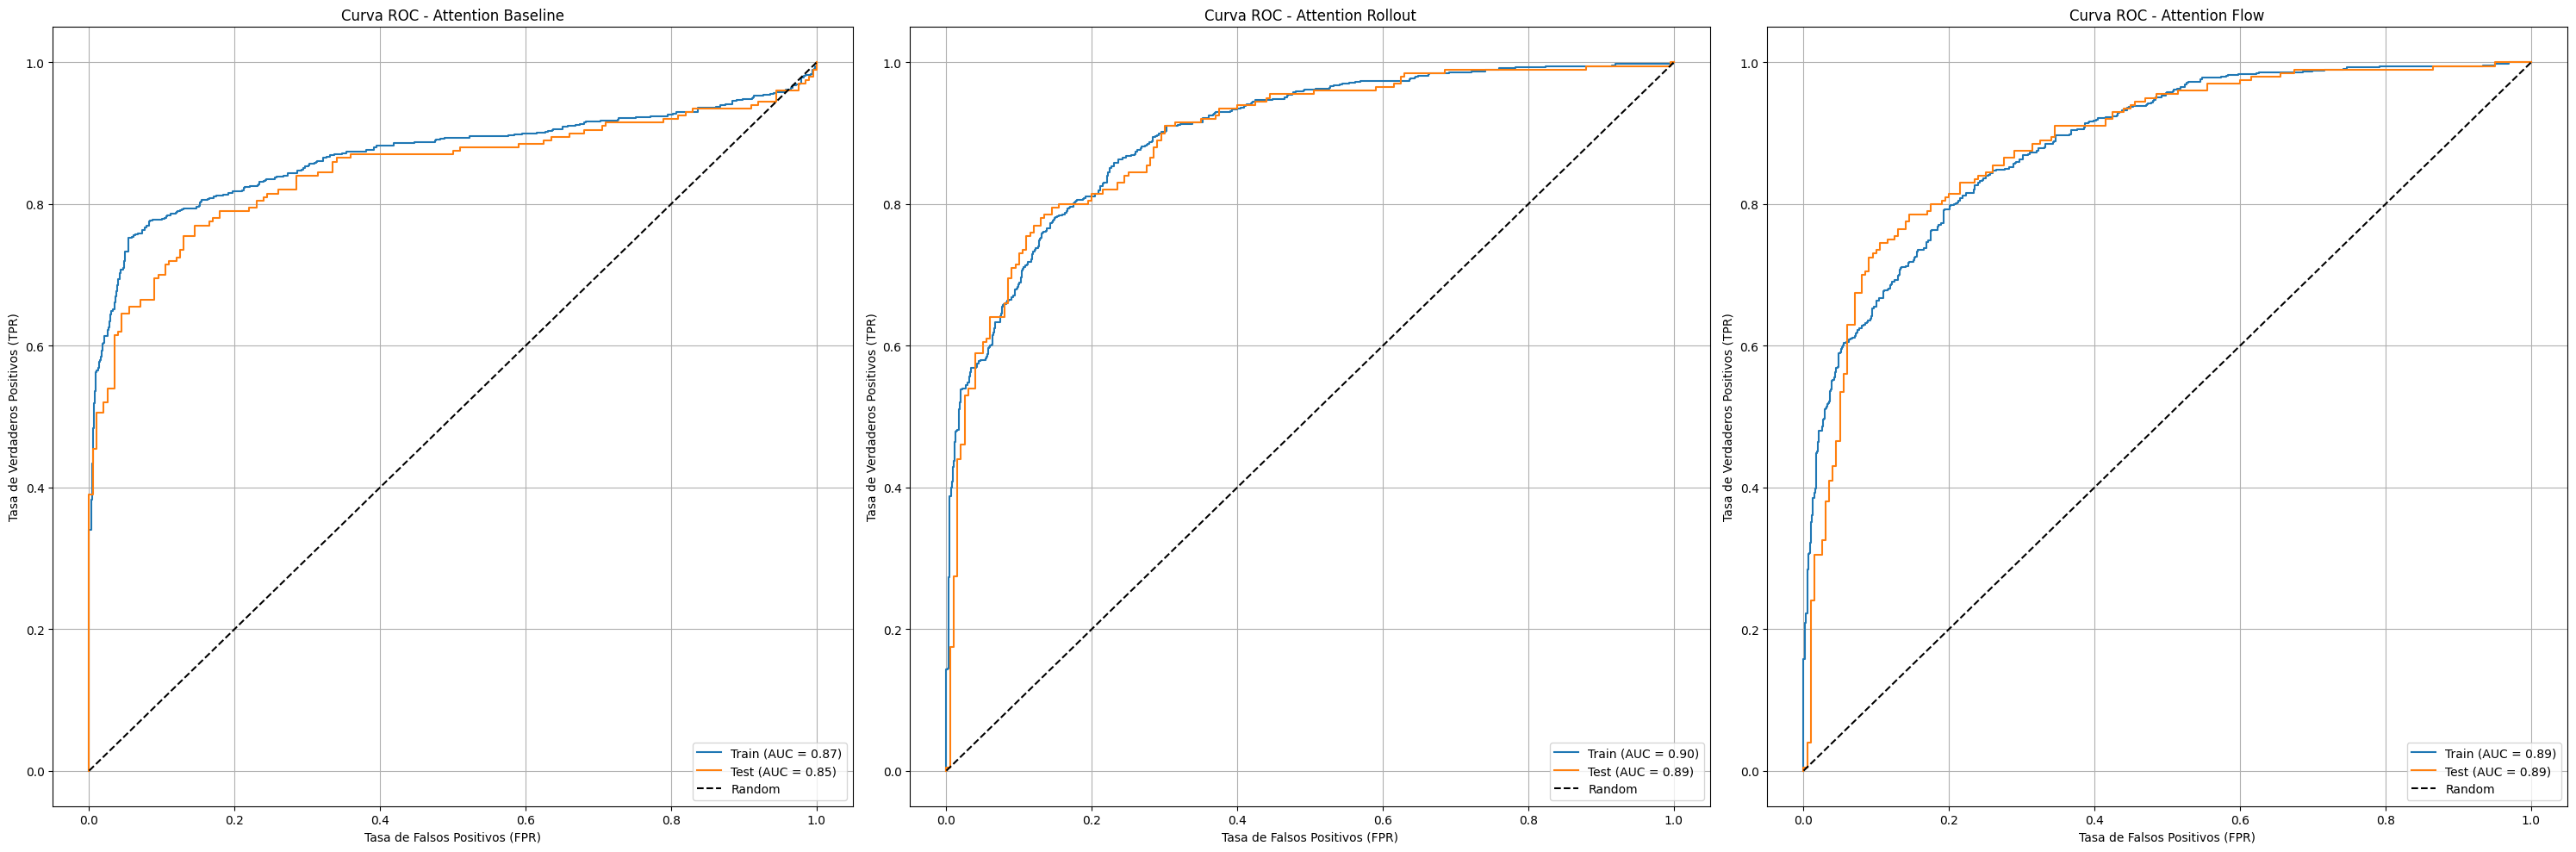

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))


# --- Primera fila: Attention Baseline ---
axes[0].plot(fpr_train_baseline, tpr_train_baseline, label=f'Train (AUC = {roc_auc_train_baseline:.2f})')
axes[0].plot(fpr_test_baseline, tpr_test_baseline, label=f'Test (AUC = {roc_auc_test_baseline:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')

axes[0].set_title('Curva ROC - Attention Baseline')
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].legend(loc='lower right')
axes[0].grid(True)


# --- Primera fila: Attention Rollout ---
axes[1].plot(fpr_train_rollout, tpr_train_rollout, label=f'Train (AUC = {roc_auc_train_rollout:.2f})')
axes[1].plot(fpr_test_rollout, tpr_test_rollout, label=f'Test (AUC = {roc_auc_test_rollout:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')

axes[1].set_title('Curva ROC - Attention Rollout')
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].legend(loc='lower right')
axes[1].grid(True)

# --- Segunda fila: Attention Flow ---
axes[2].plot(fpr_train_flow, tpr_train_flow, label=f'Train (AUC = {roc_auc_train_flow:.2f})')
axes[2].plot(fpr_test_flow, tpr_test_flow, label=f'Test (AUC = {roc_auc_test_flow:.2f})')
axes[2].plot([0, 1], [0, 1], 'k--', label='Random')

axes[2].set_title('Curva ROC - Attention Flow')
axes[2].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[2].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[2].legend(loc='lower right')
axes[2].grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

Los valores de las curvas ROC son muy similares para los tres métodos, lo cual muestra que, en los tres casos, los modelos de regresión logística obtenidos son muy buenos.

# Conclusión

En este trabajo hemos aplicado y comparado tres métodos de explicabilidad —un enfoque baseline, Attention Rollout y Attention Flow— para analizar los patrones de atención del token [CLS] en un modelo transformer entrenado para clasificar péptidos como AMP o no AMP. Al transformar las atenciones en vectores asociados a la presencia de aminoácidos en cada péptido, hemos generado un conjunto de datos interpretable que nos ha permitido realizar distintos análisis estadísticos.

Los resultados muestran que tanto Attention Rollout como Attention Flow presentan diferencias significativas respecto al modelo base, especialmente en su capacidad para identificar patrones de atención sobre aminoácidos relevantes para la clasificación. Los diagramas de correlación, los análisis de varianza y los modelos predictivos entrenados sobre estos vectores de atención indican que ciertos residuos reciben consistentemente mayor atención en los péptidos AMP, lo que puede reflejar señales estructurales relevantes para la función antimicrobiana.

Este enfoque aporta una vía útil para interpretar modelos basados en atención en el contexto bioinformático, facilitando la identificación de señales biológicas relevantes directamente desde los pesos del modelo. A futuro, esta metodología podría extenderse a tareas como la predicción de propiedades específicas de péptidos o la ingeniería de nuevas secuencias funcionales.